<a href="https://colab.research.google.com/github/StefanoBergia/Tesi_Anomaly_Detection/blob/main/UNSUPERVISED_ANOMALY_DETECTION_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIBRERIE

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
#import plotly.express as px
#import plotly.graph_objects as go
from google.colab import drive
from google.colab import widgets
from plotly.subplots import make_subplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors
import datetime
import time
import warnings
#from statsmodels.tools.sm_exceptions import ConvergenceWarning
#from statsmodels.tools.sm_exceptions import UserWarning

colors=mcolors.TABLEAU_COLORS
colormap=np.array(list(list(zip(*colors.items()))[1]))
colormap=np.concatenate((colormap, colormap[1:],colormap[1:]), axis=0)
#print(colormap)
#!pip install pmdarima
#from pmdarima import auto_arima

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


DATASET

In [ ]:
min_date='2021-07-24 00:00:00'
max_date='2021-08-27 23:59:00'

drive.mount('/content/gdrive',force_remount=True)
df_original = pd.read_csv('/content/gdrive/MyDrive/Dati_Tesi/PIVOT_WLS_HVST_1_MONTH.csv', parse_dates=['TS'], index_col='TS')
df_original.index = pd.DatetimeIndex(df_original.index)
df_original=df_original.asfreq(freq='60s',method='ffill')
df=df_original.copy()
df=df.loc[min_date:max_date]

columns=df.columns.drop(['431','907']).drop(['436','480','482','777','781','783','910'])

###########
#columns=['272']
##########

period_length=1440

print(columns)

Mounted at /content/gdrive
Index(['272', '430', '776', '780', '782', '784', '908', '909'], dtype='object')


*   272: OpenSocketsCurrentCount
*   430: OpenSessionCurrentCount
*   480: CompletedRequests
*   482: PendingRequests
*   776: ExecuteThreadIdleCount (sono pronti per essere eseguiti ma attendono un task)
*   777: ExecuteThreadTotalCount
*   780: PendingUserRequestCount
*   782: StandByThreadCount (sono in stato di wait di una risorsa)
*   784: Througput (mean number of request completed per second
*   908: HeapFreePercent
*   909 HeapSizeCurrent






In [ ]:
df.head()

272  430  431  ...  908         909         910
TS                                  ...                             
2021-07-24 00:00:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:01:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:02:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:03:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:04:36    3   17  224  ...   74  8272216064  8272216064

[5 rows x 17 columns]

In [ ]:
df.tail()

272  430  431  ...  908         909         910
TS                                  ...                             
2021-08-27 23:54:36    3   31  188  ...   73  8158445568  8158445568
2021-08-27 23:55:36    3   31  188  ...   73  8158445568  8158445568
2021-08-27 23:56:36    3   31  188  ...   73  8158445568  8158445568
2021-08-27 23:57:36    3   29  188  ...   73  8158445568  8158445568
2021-08-27 23:58:36    4   31  188  ...   72  8158445568  8158445568

[5 rows x 17 columns]

In [ ]:
print(len(df.index))

50399


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

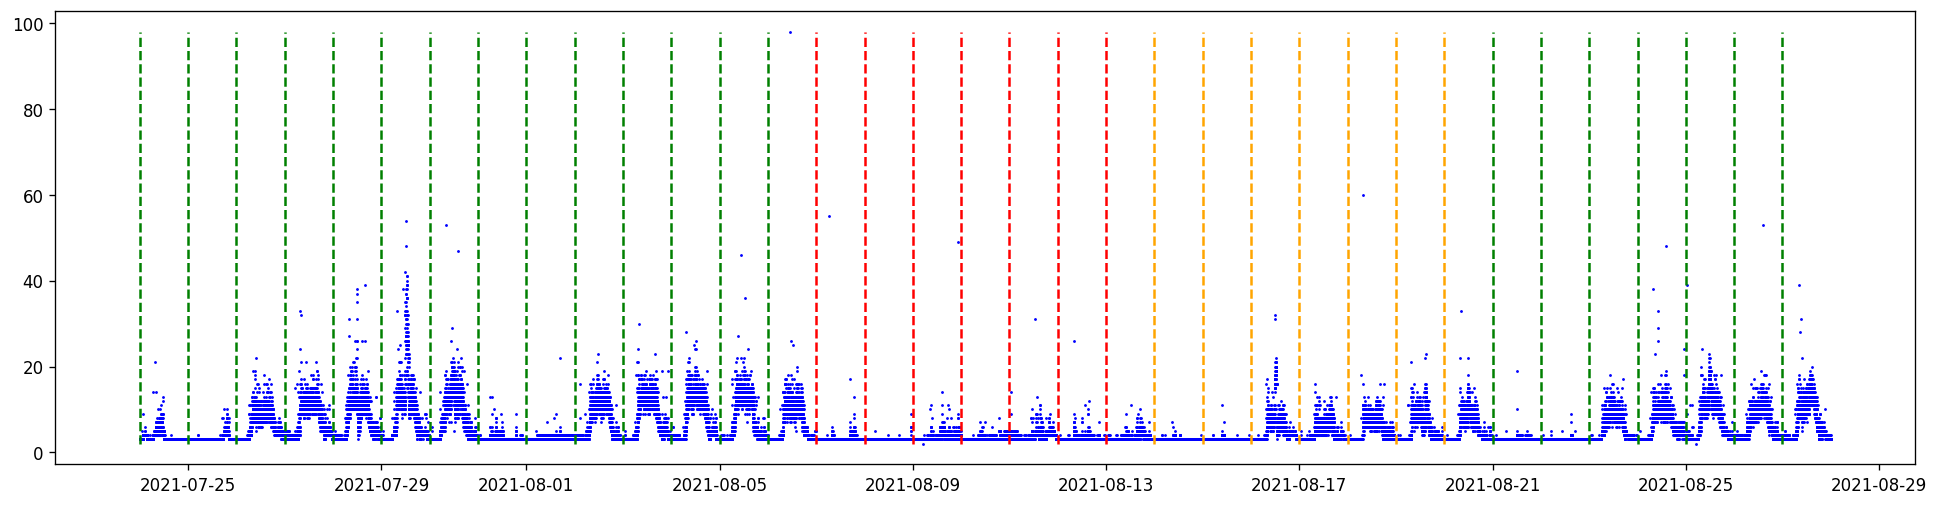

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

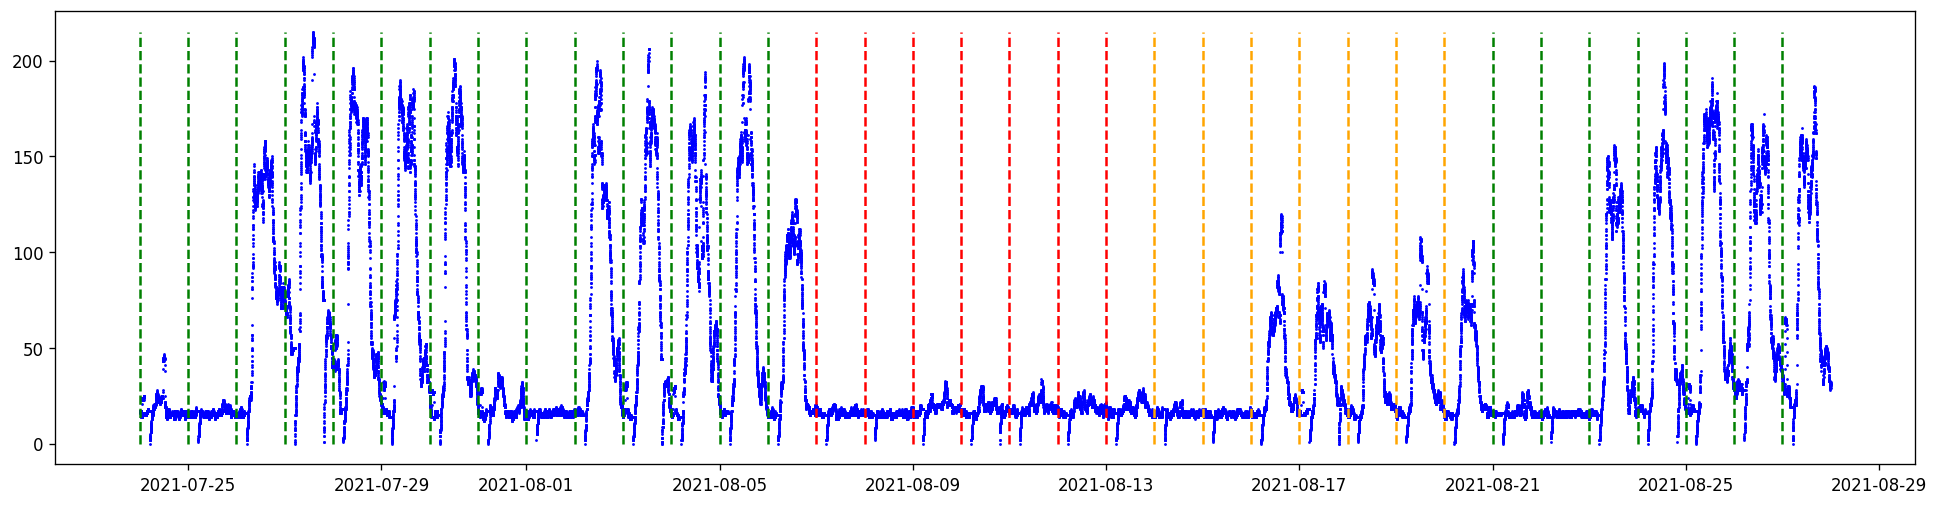

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

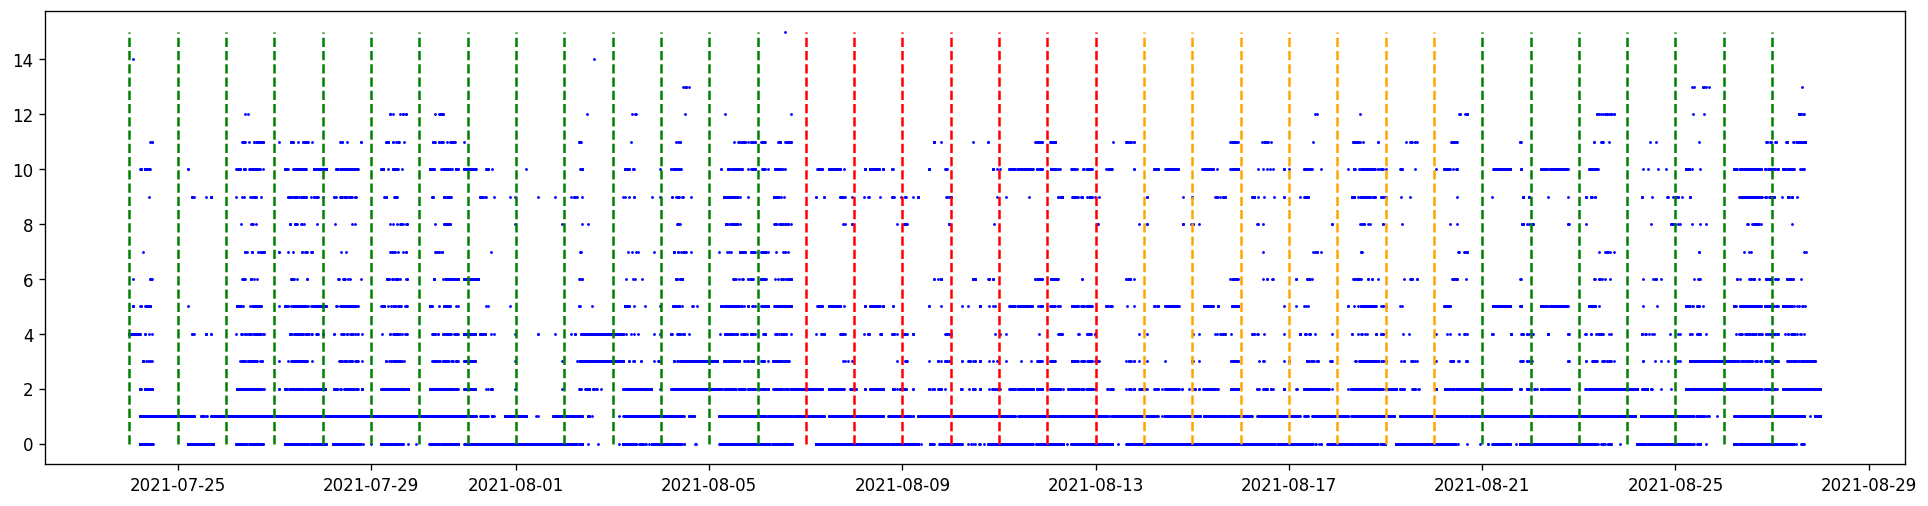

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

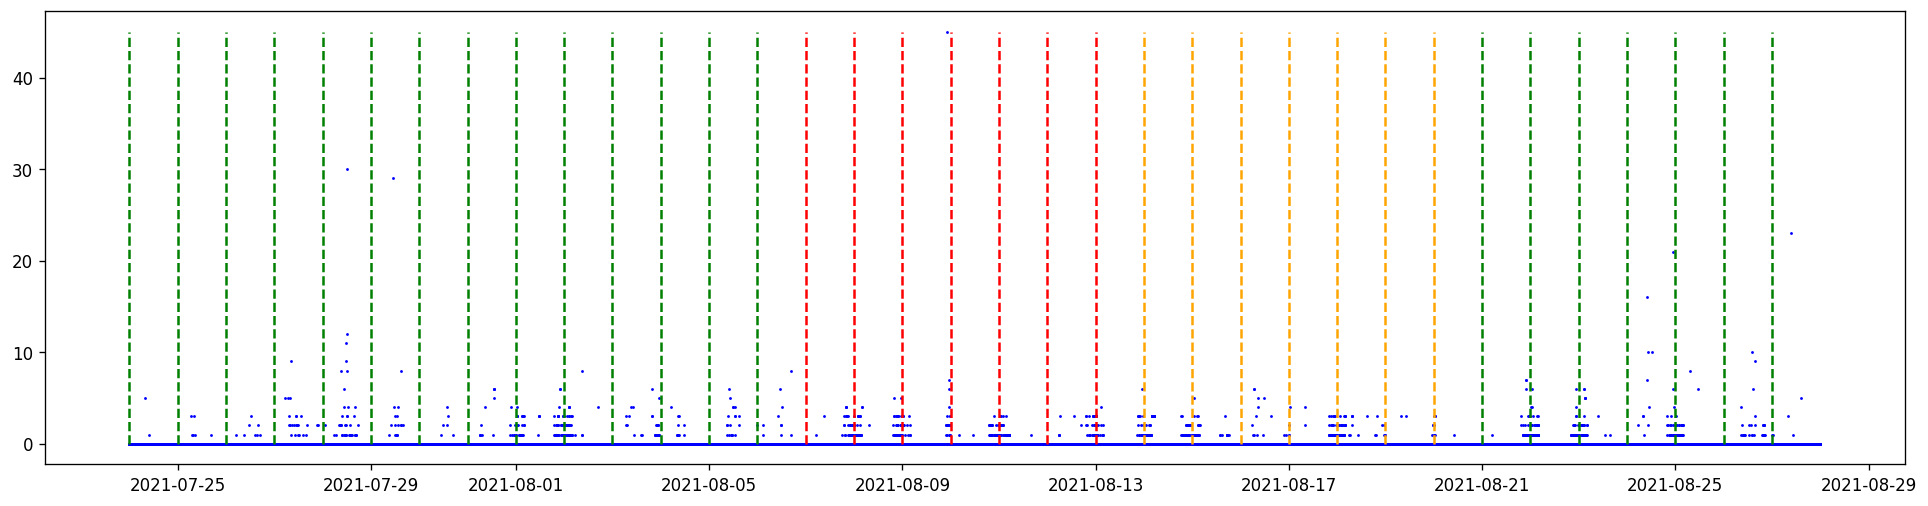

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

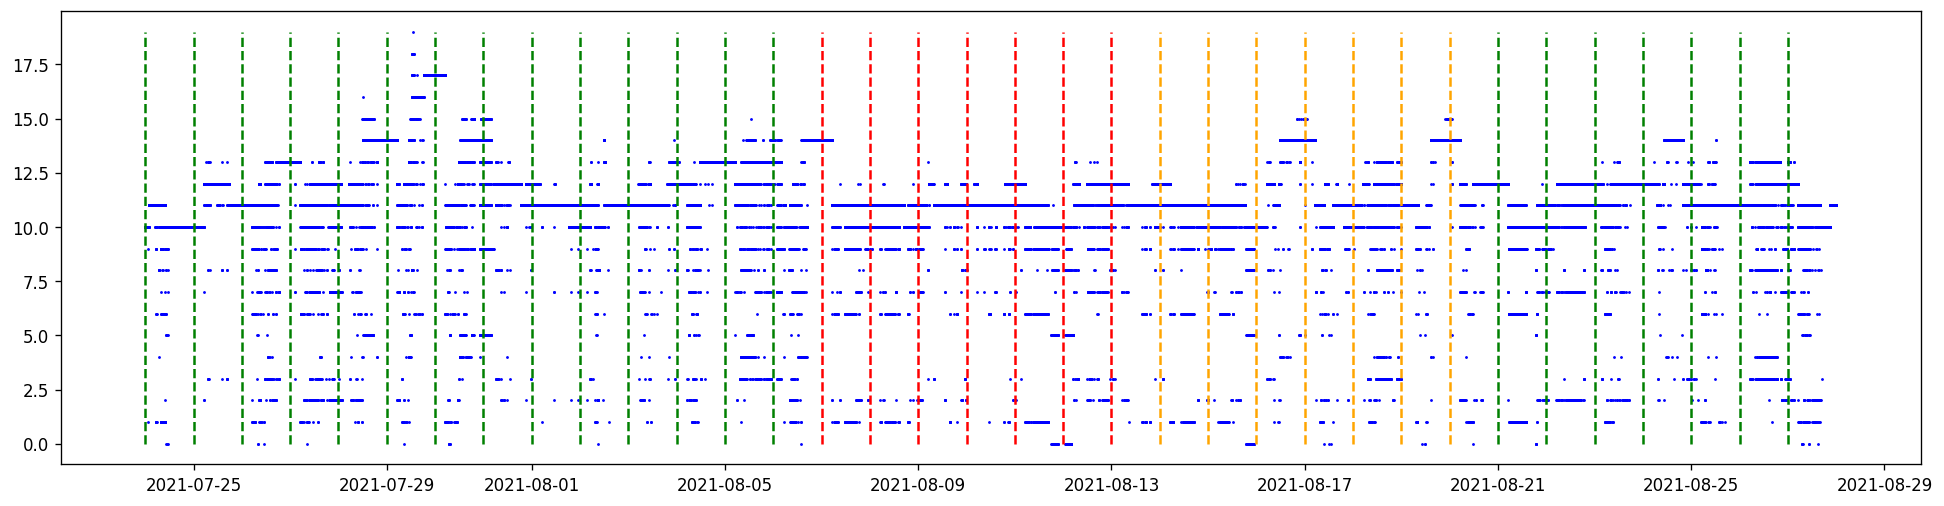

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

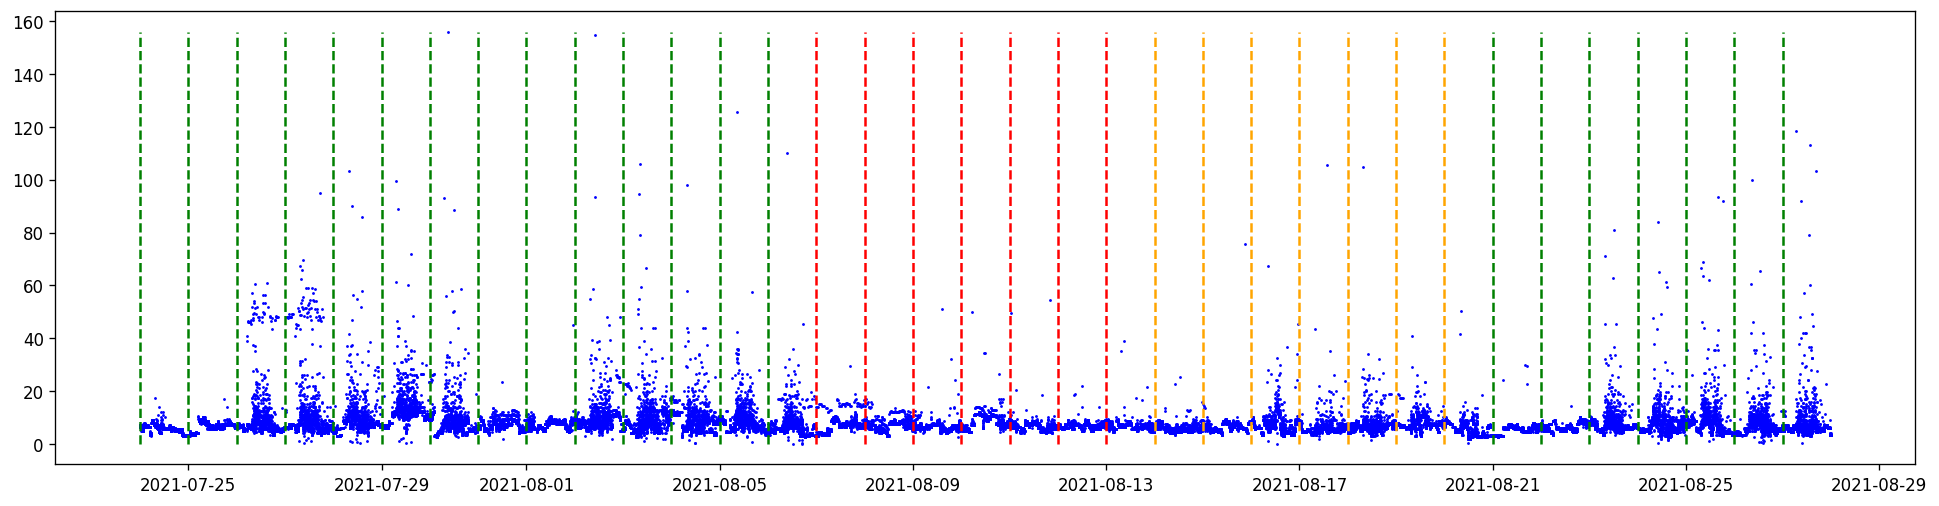

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

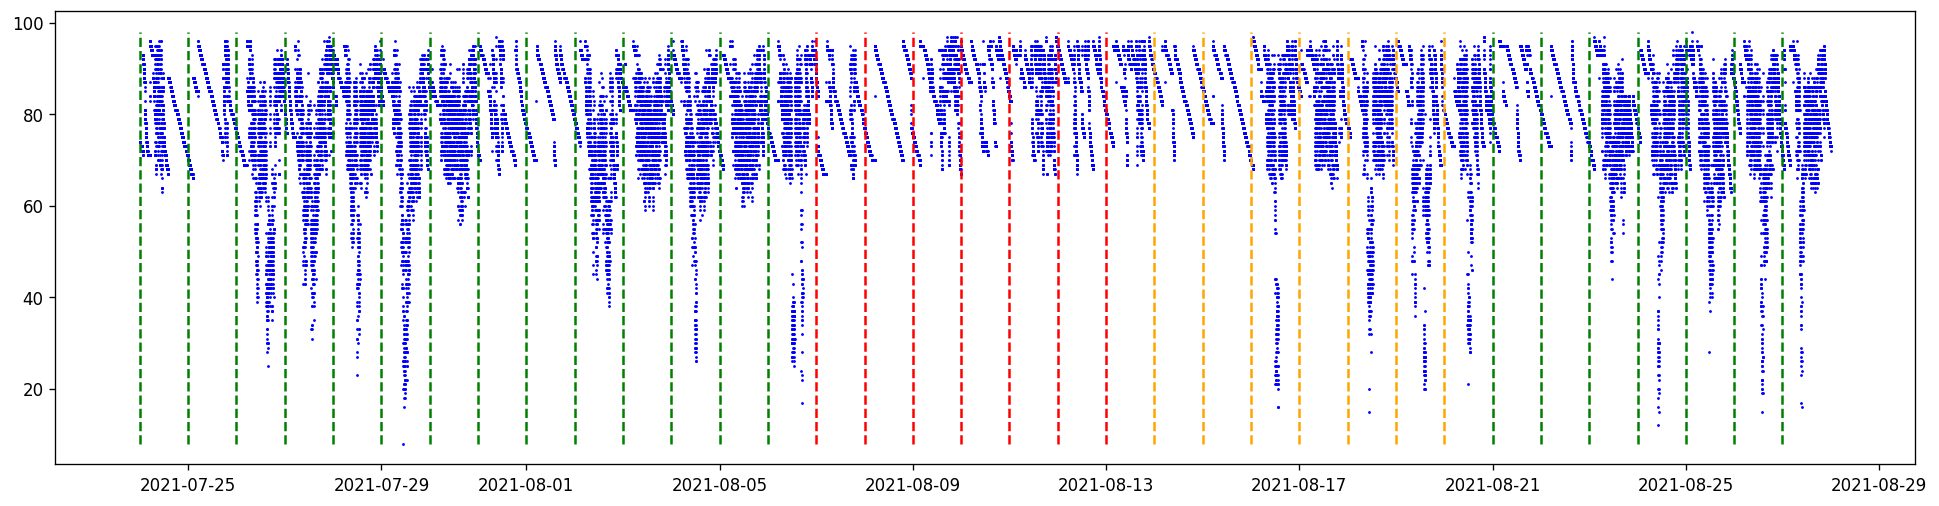

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

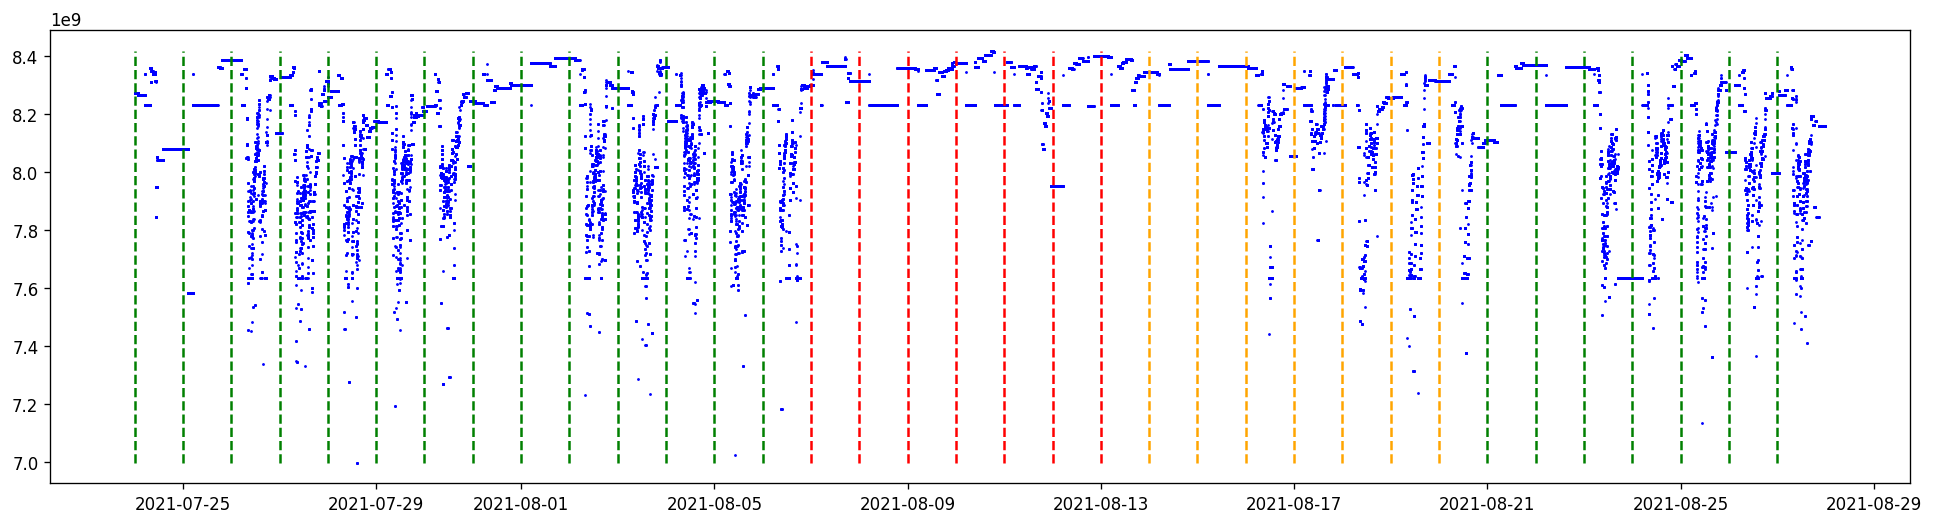

<IPython.core.display.Javascript object>

In [ ]:
tb = widgets.TabBar([columns[i] for i in range(len(columns))])

midnights = np.array([])
colors=np.array([])
count=0
for i in range(0,len(df.index),period_length):
  midnights=np.append(midnights,df.index[i])
  if count <14 or count >=28:
    colors=np.append(colors,'green')
  else:
    if count >= 14 and count <21:
      colors=np.append(colors,'red')
    else :
      colors=np.append(colors,'orange')
  count=count+1


for col in columns:
  with tb.output_to(col):
    plt.rcParams.update({'figure.figsize': (25, 10), 'figure.dpi': 120})
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.scatter(x=df.index, y=df[col], color='blue',s=0.5)
    ax.vlines(midnights, df[col].min(), df[col].max(), linestyles='dashed', colors=colors)


    fig.show();

In [ ]:
first_two_weeks=df.loc['2021-07-24 00:00:00':'2021-08-06 23:59:00']
last_week=df.loc['2021-08-21 00:00:00': '2021-08-27 23:59:00']
strange_week=df.loc['2021-08-14 00:00:00': '2021-08-20 23:59:00']
remove_week=df.loc['2021-08-07 00:00:00':'2021-08-13 23:59:00']

In [ ]:
strange_week=strange_week*1
last_week.index=strange_week.index
strange_week.index=remove_week.index

In [ ]:
df=pd.concat([first_two_weeks, strange_week,last_week])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

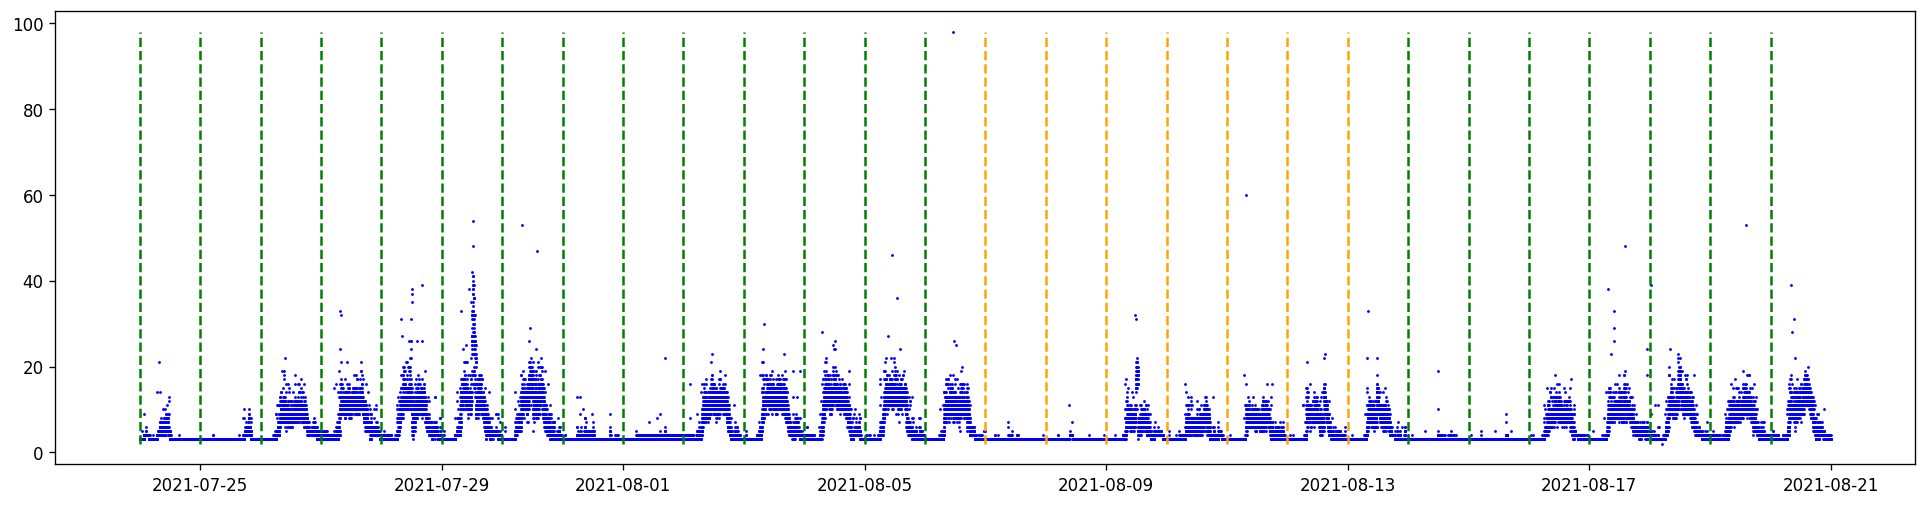

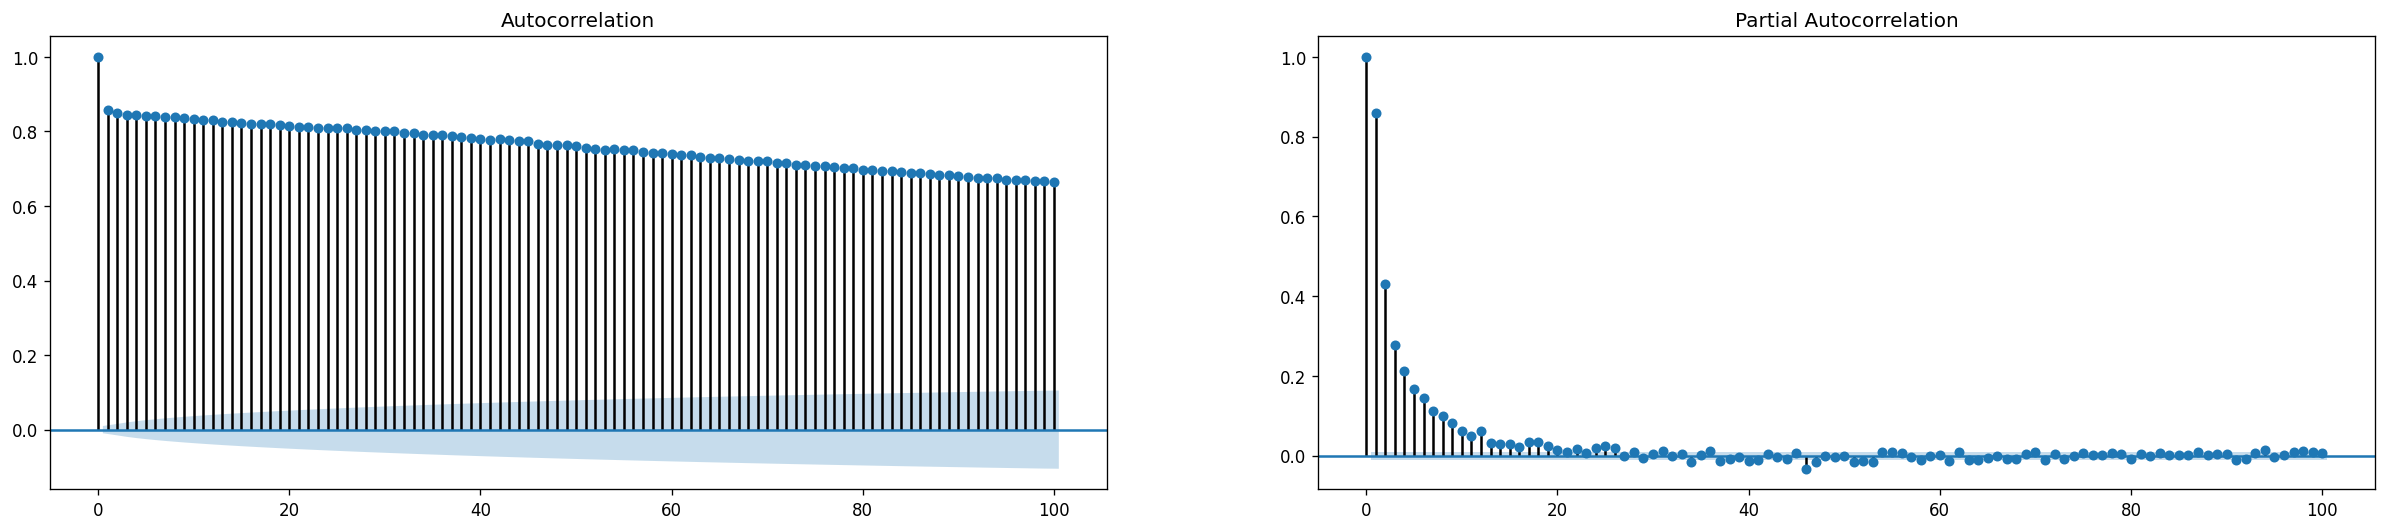

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

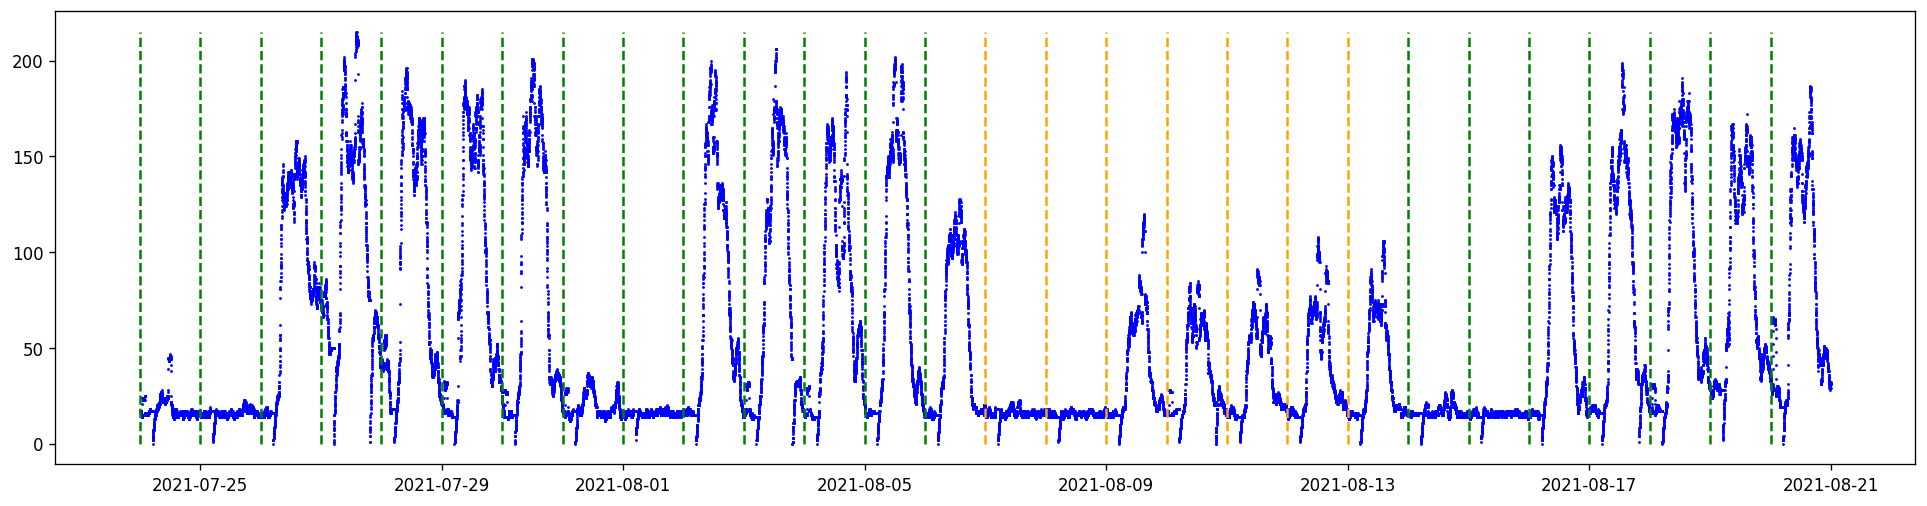

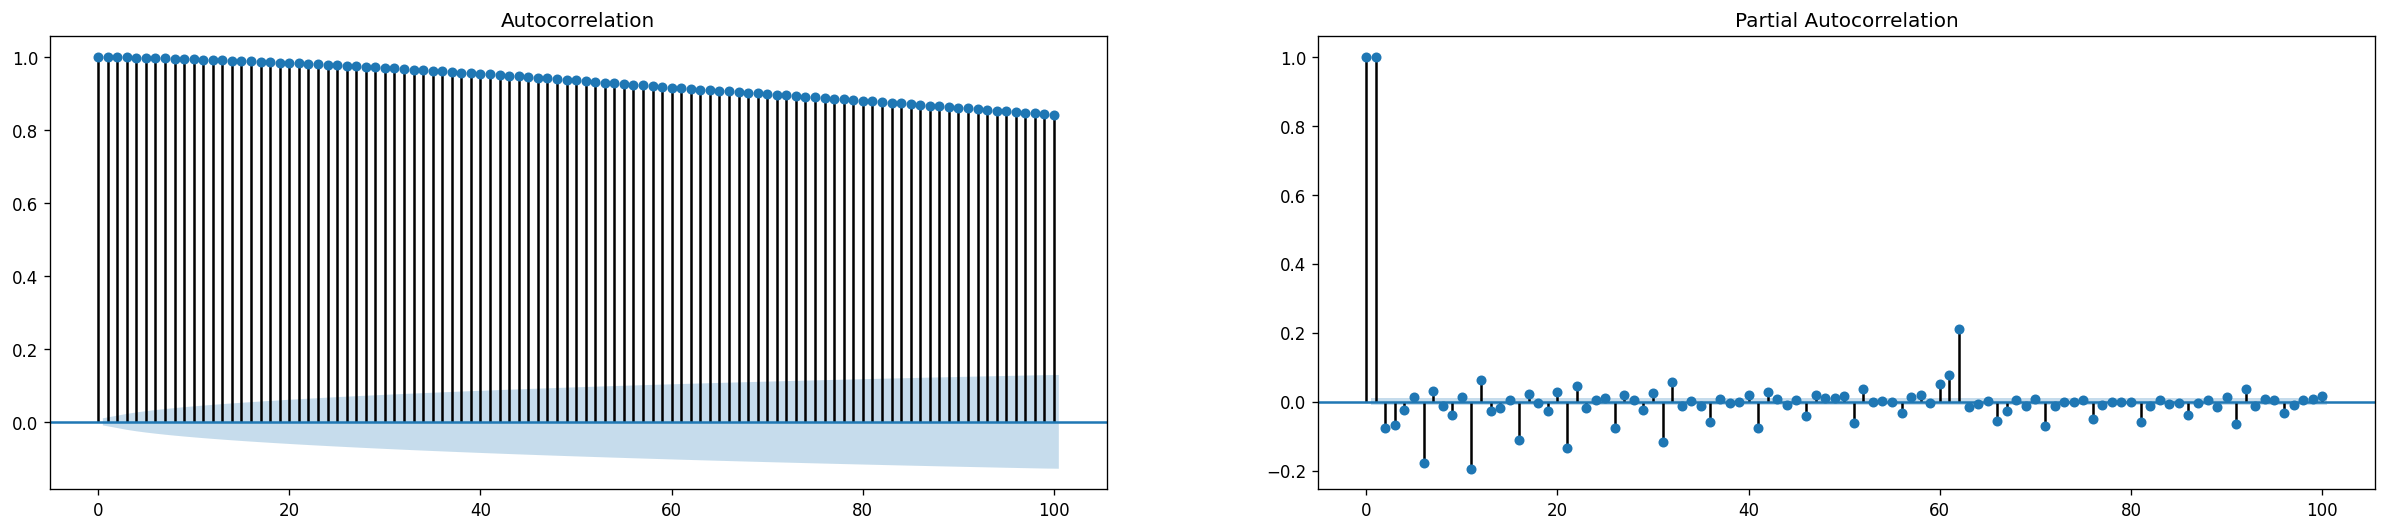

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

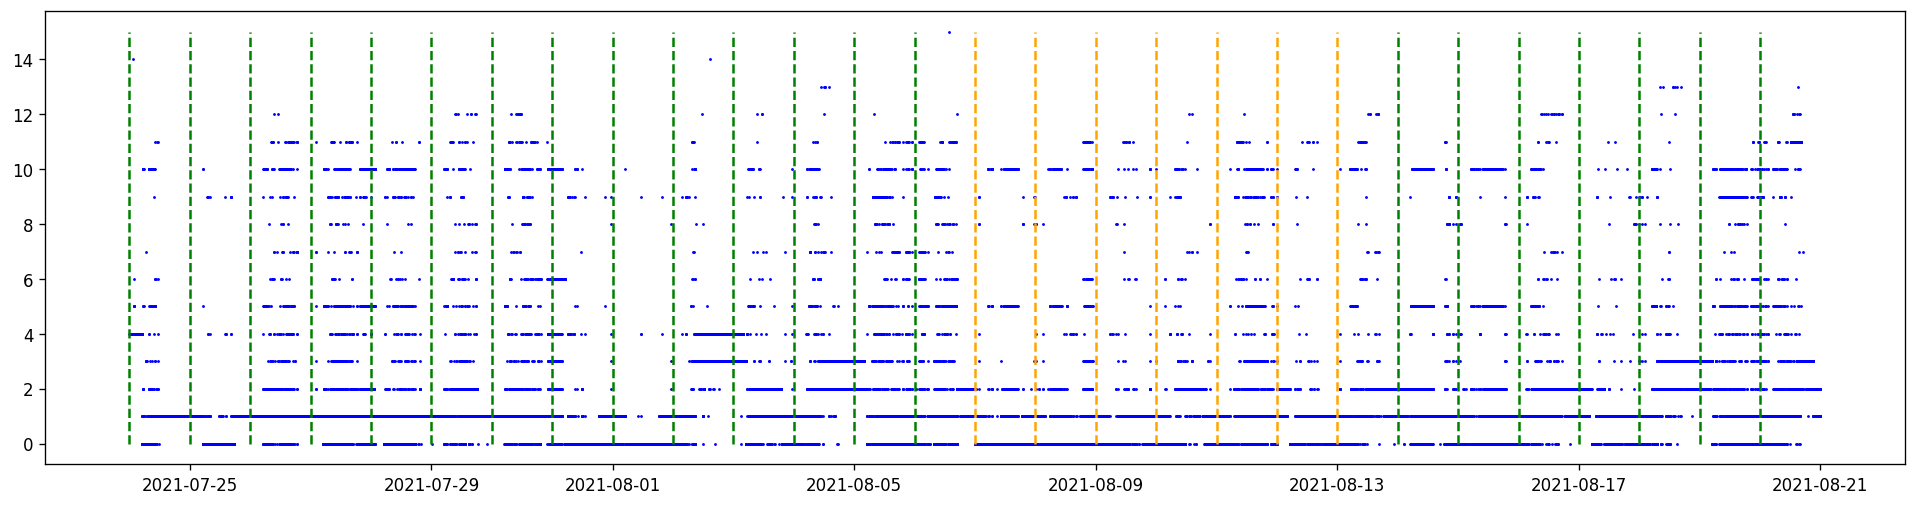

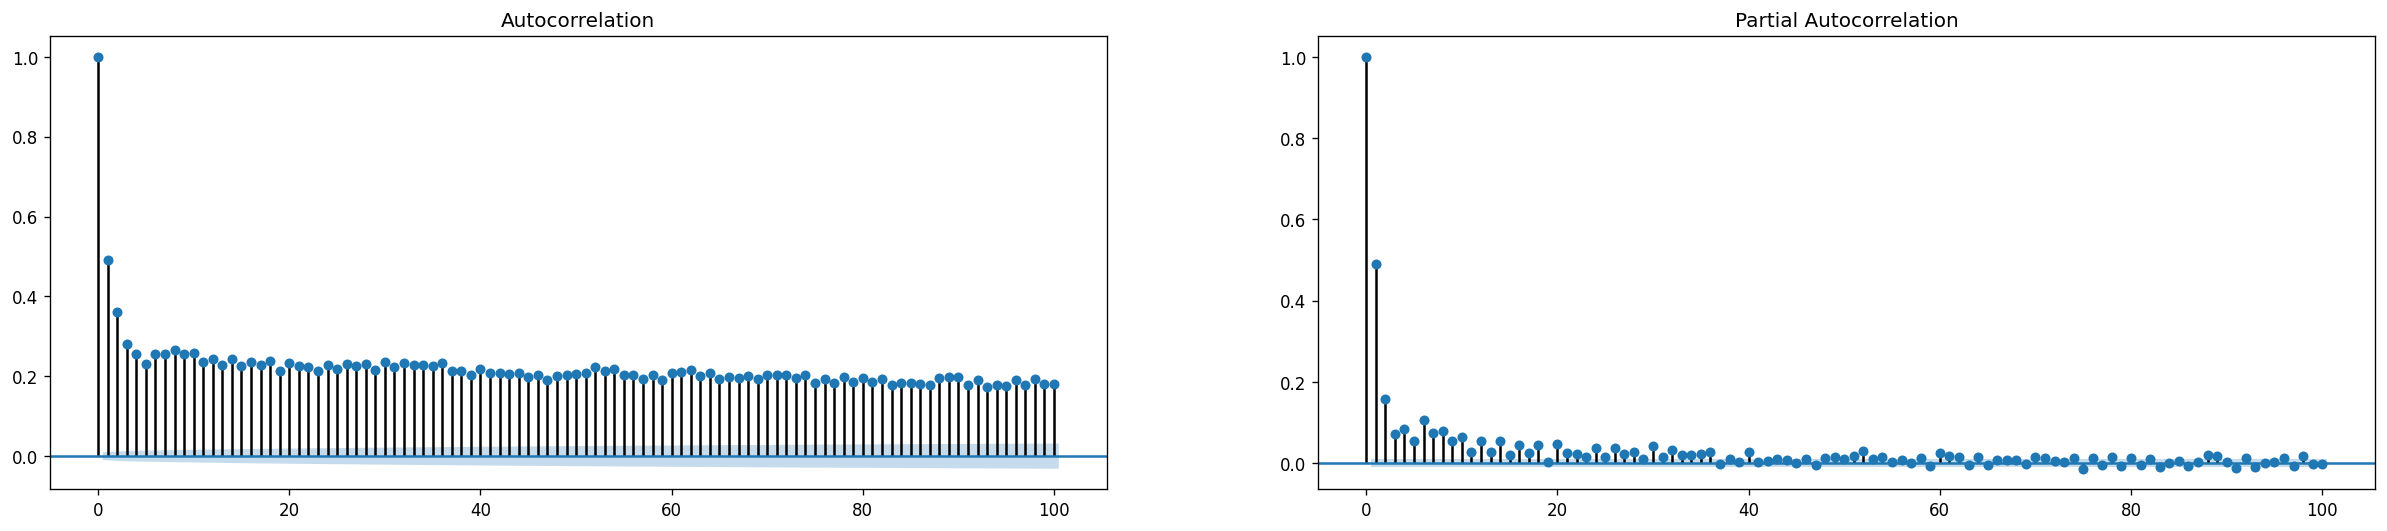

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

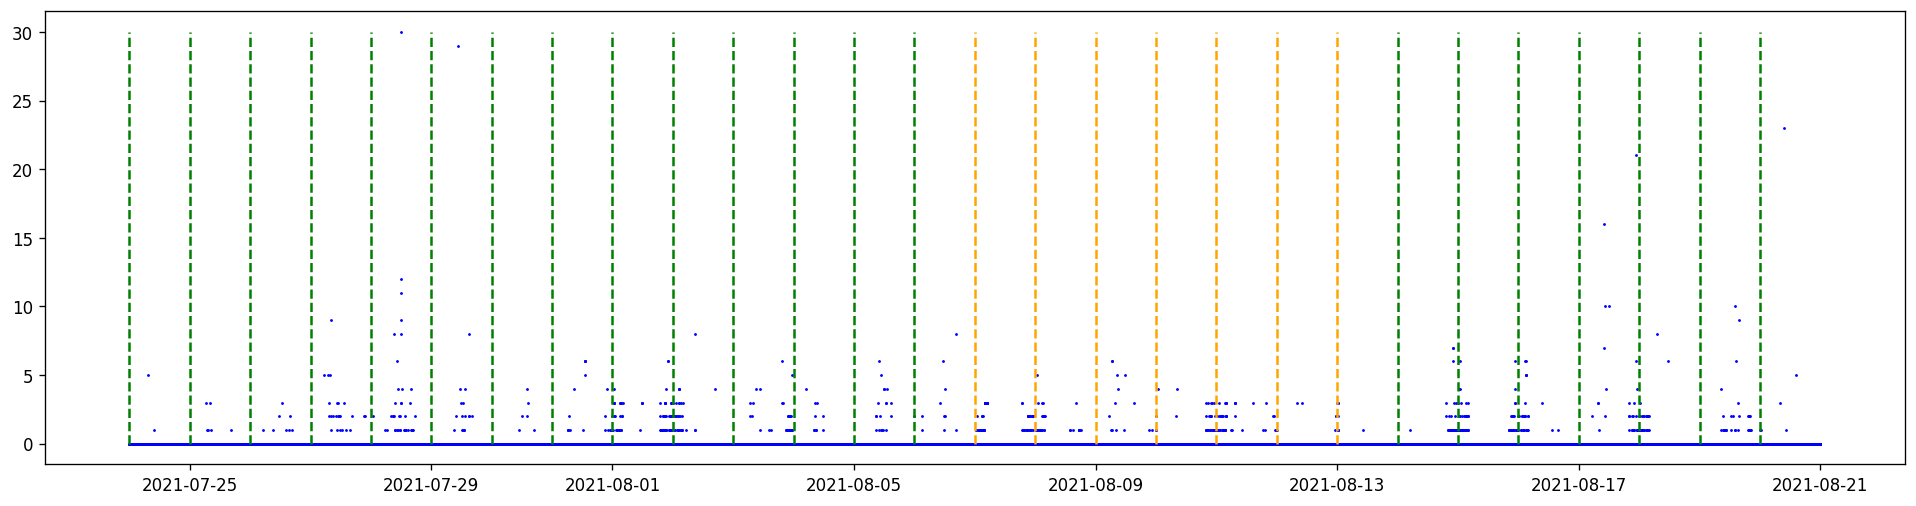

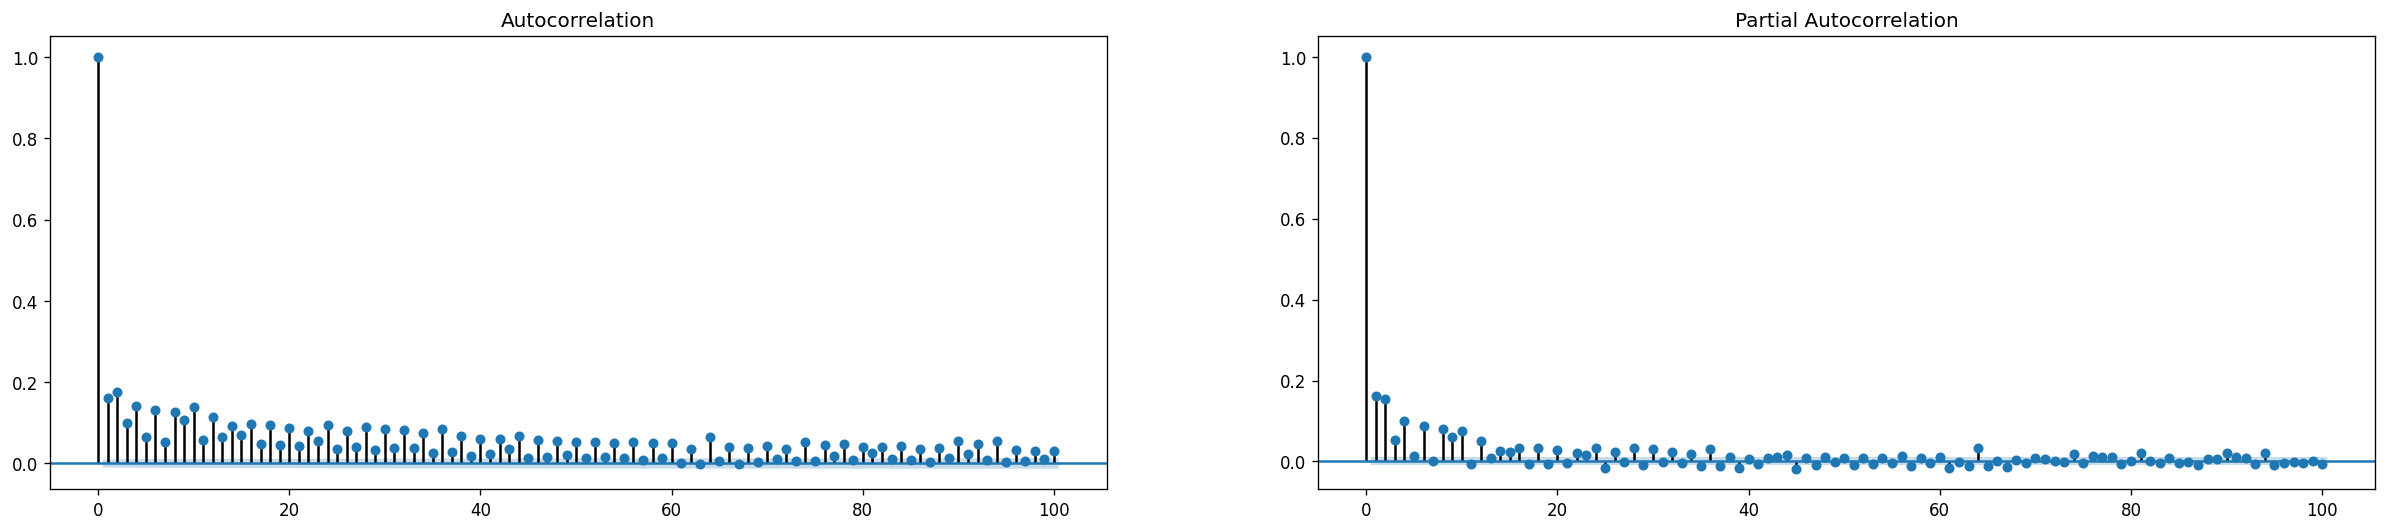

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

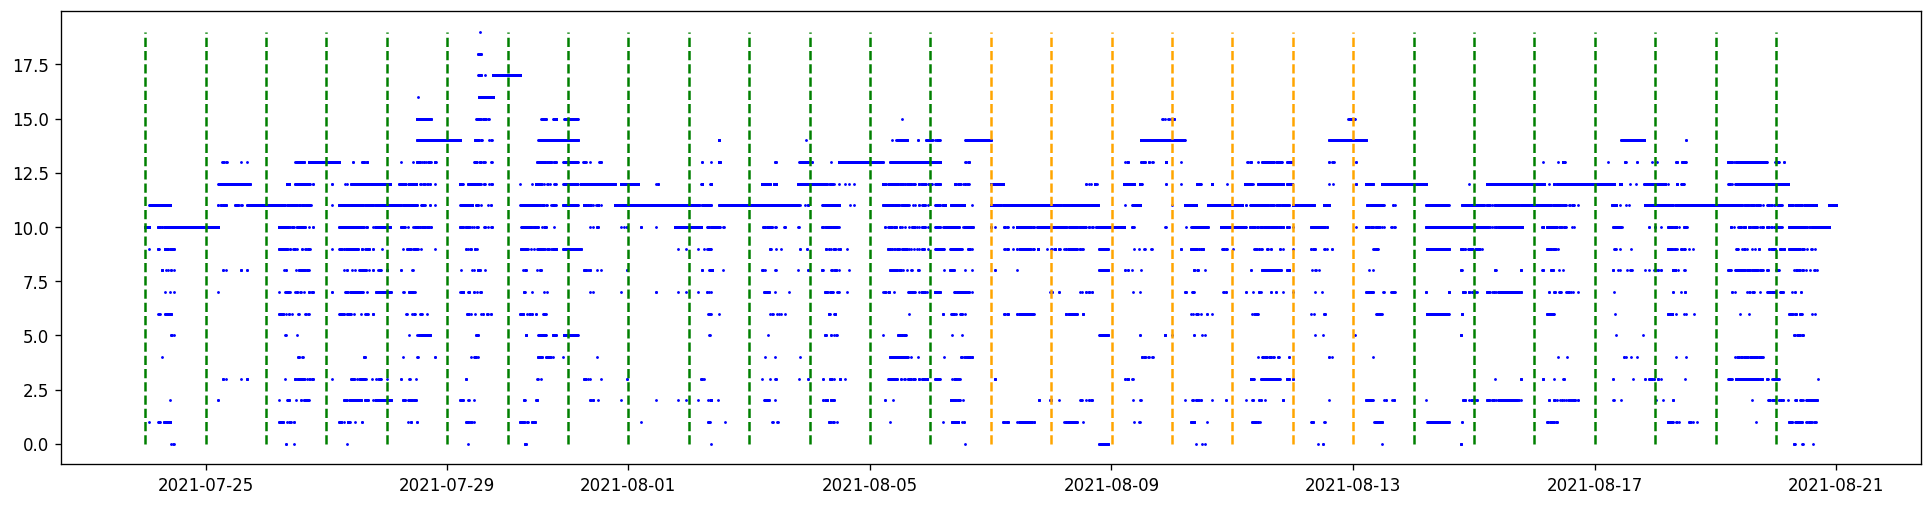

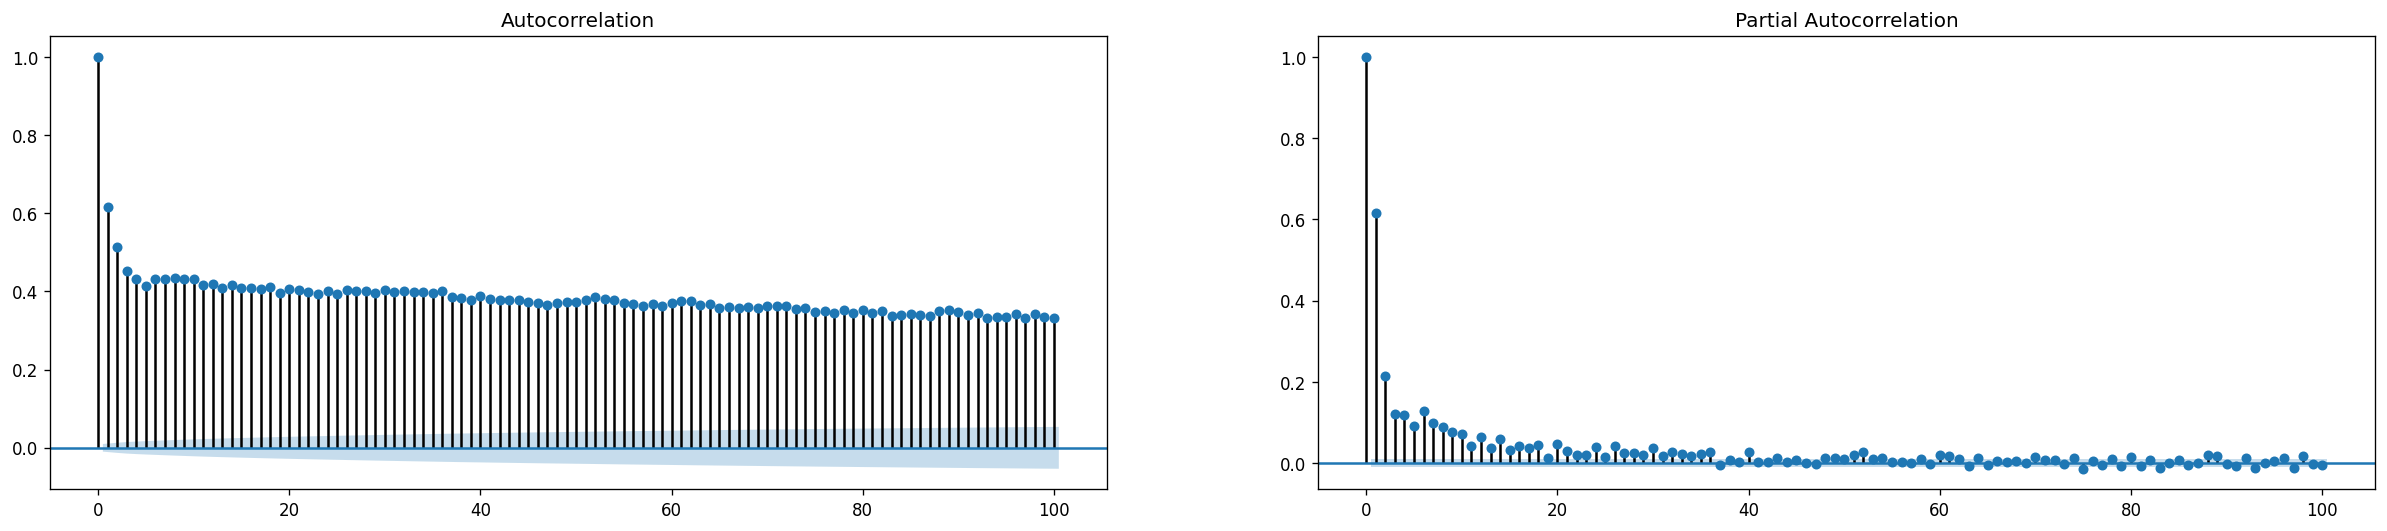

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

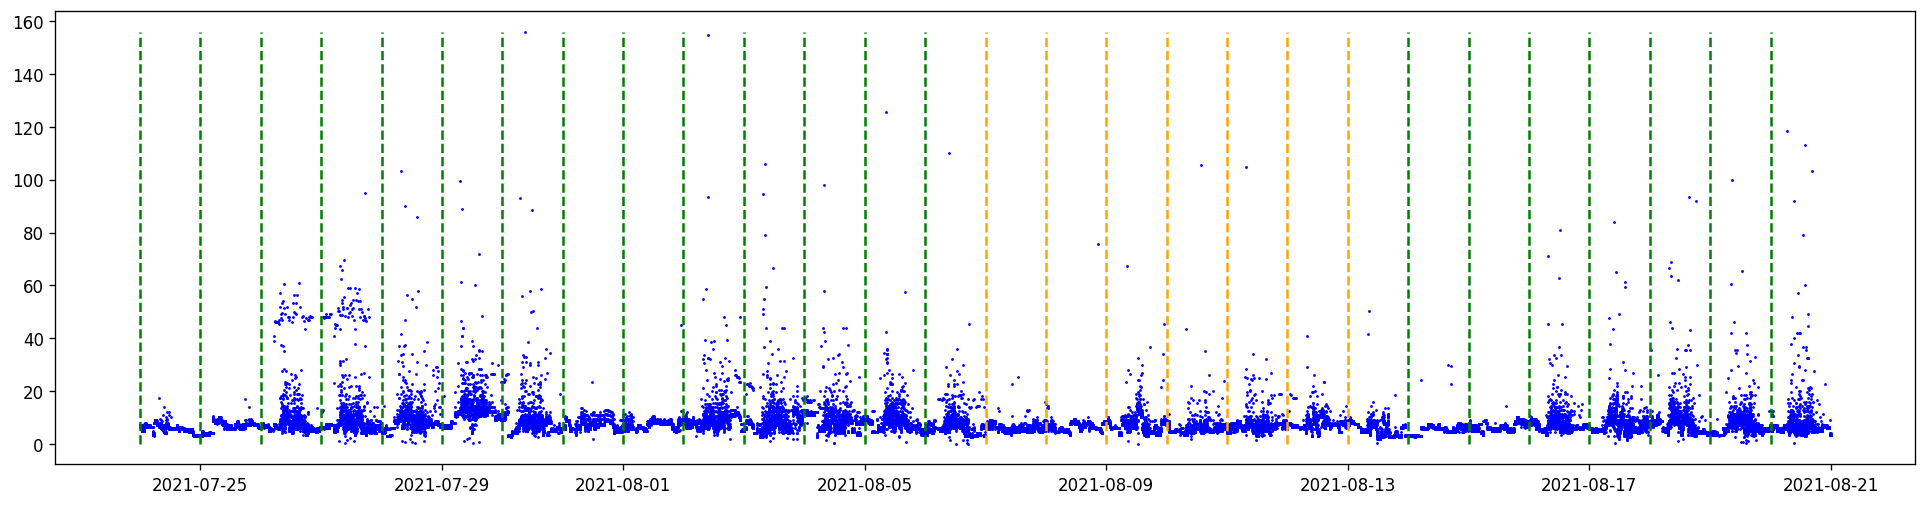

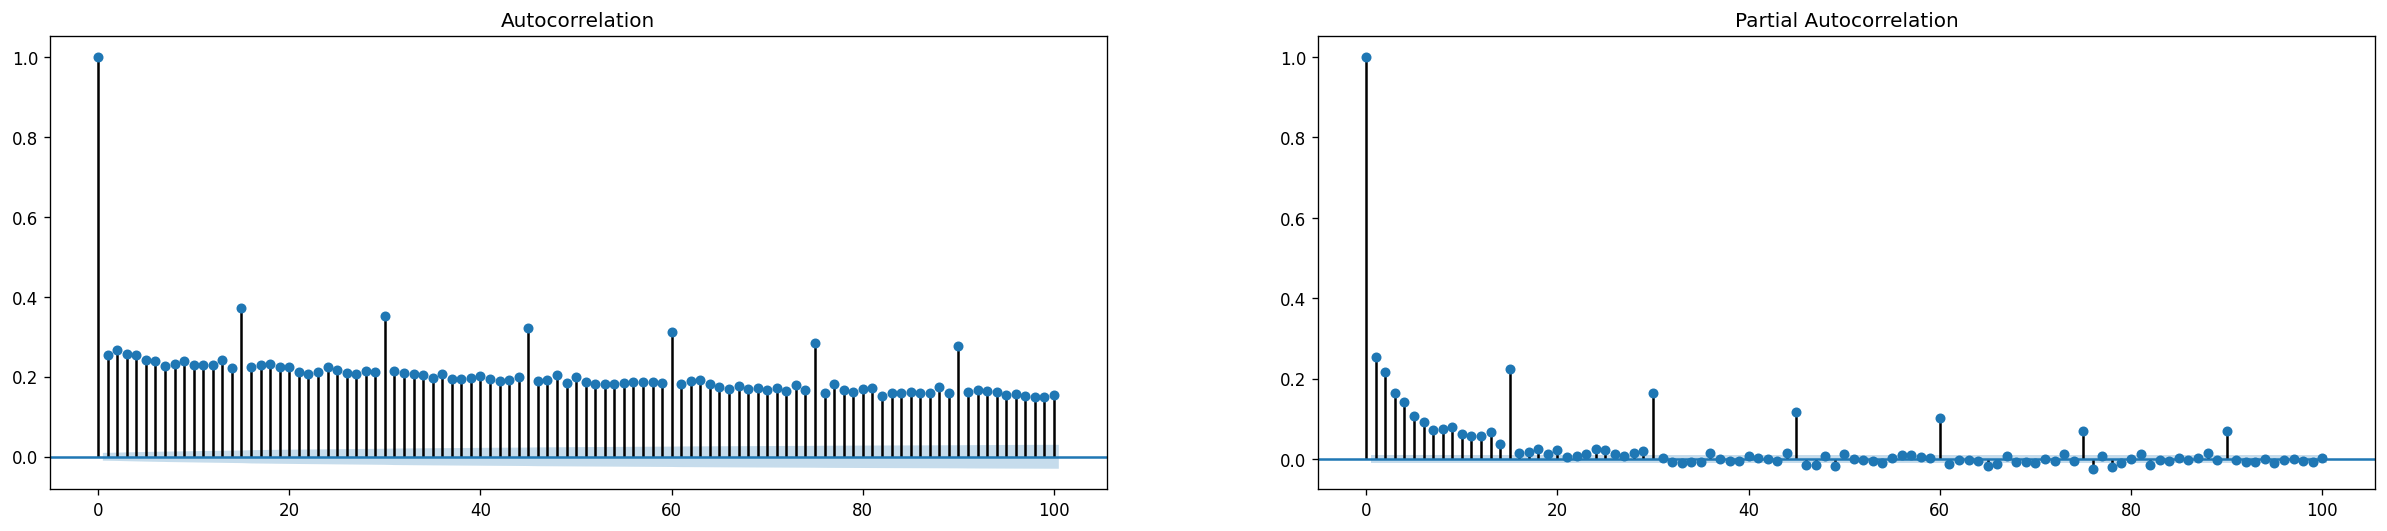

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

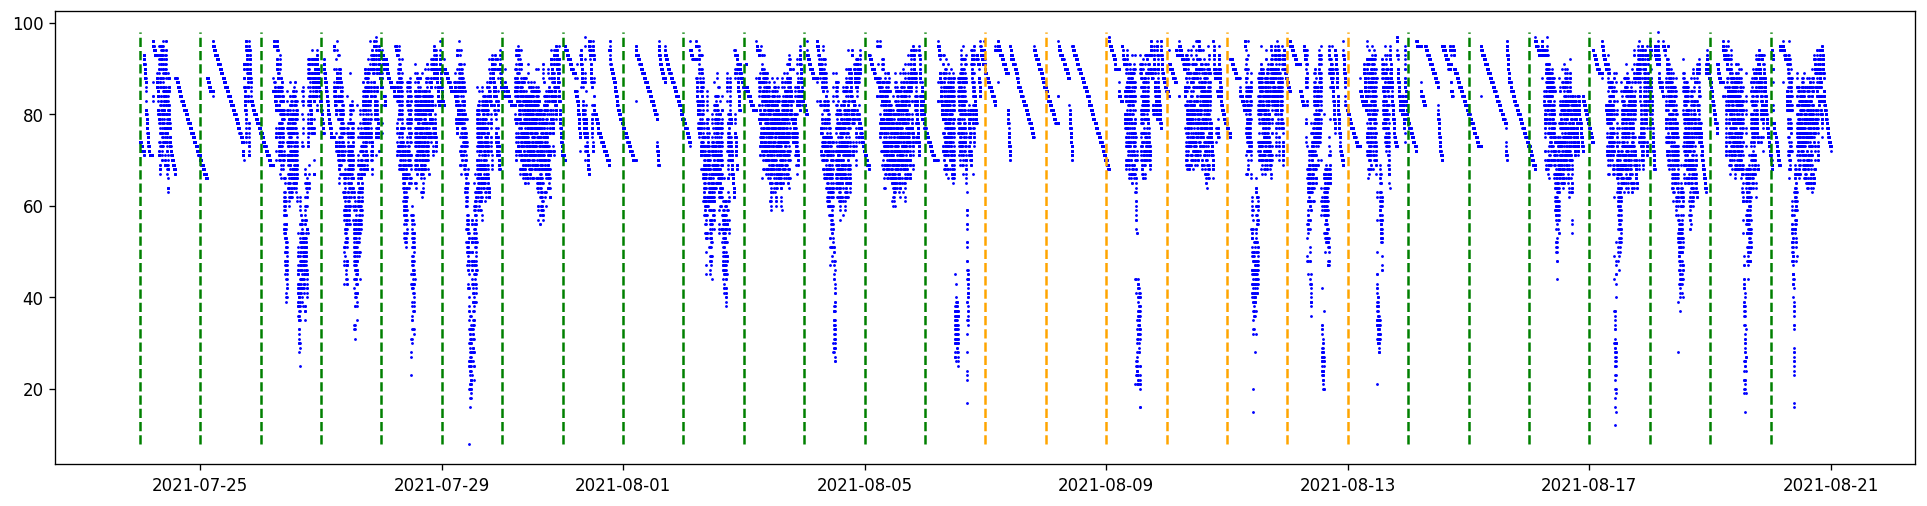

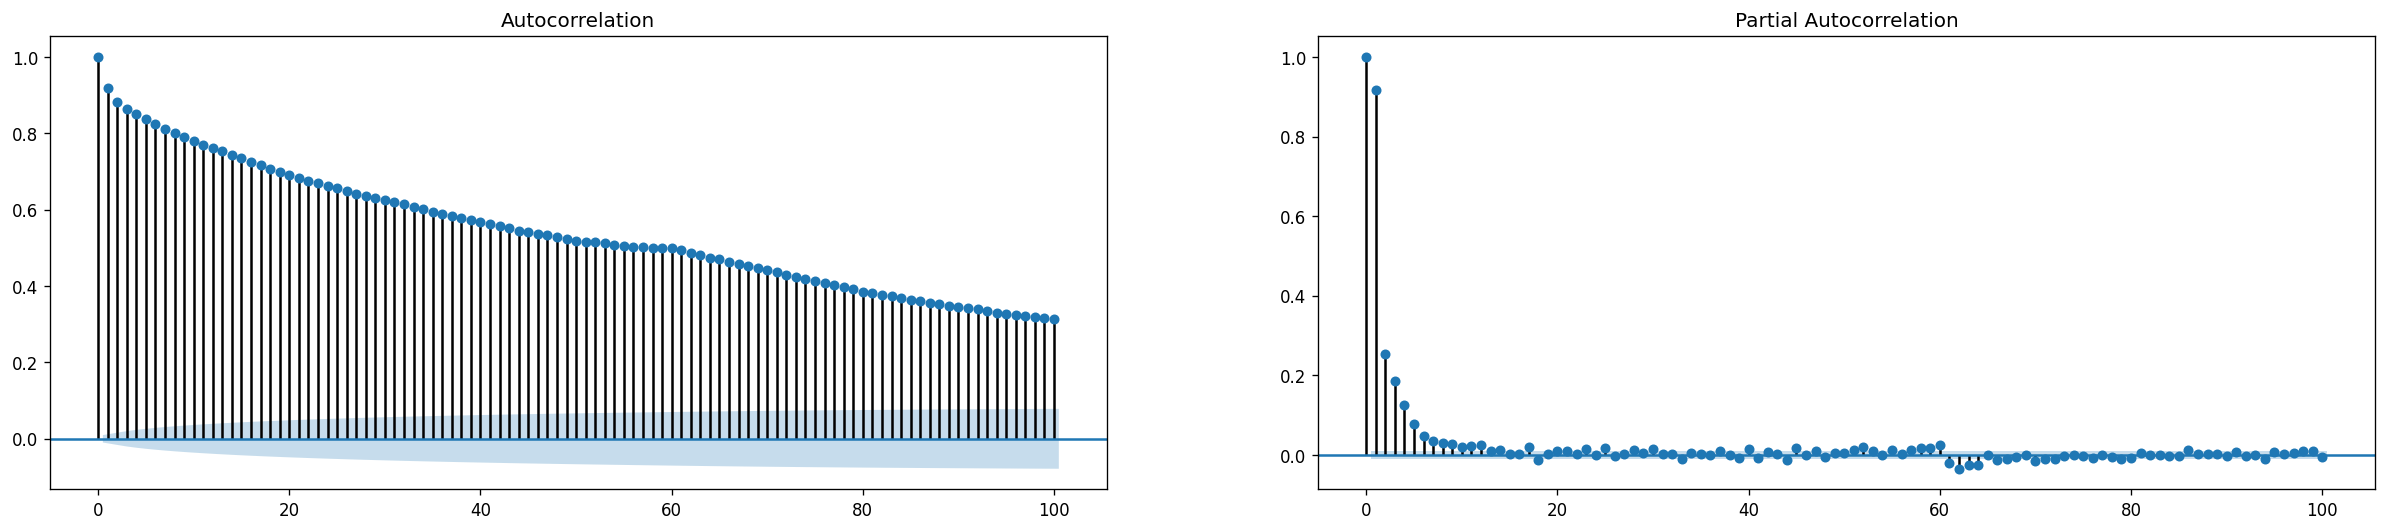

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

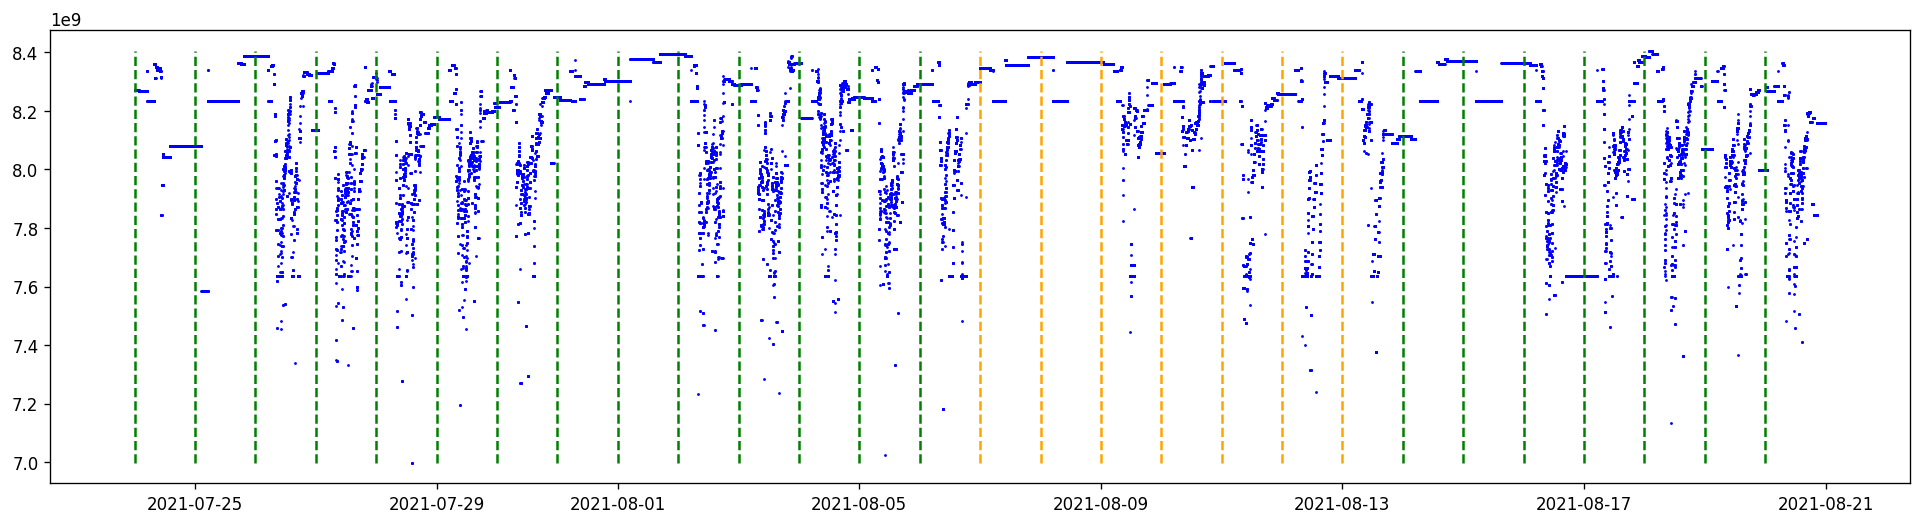

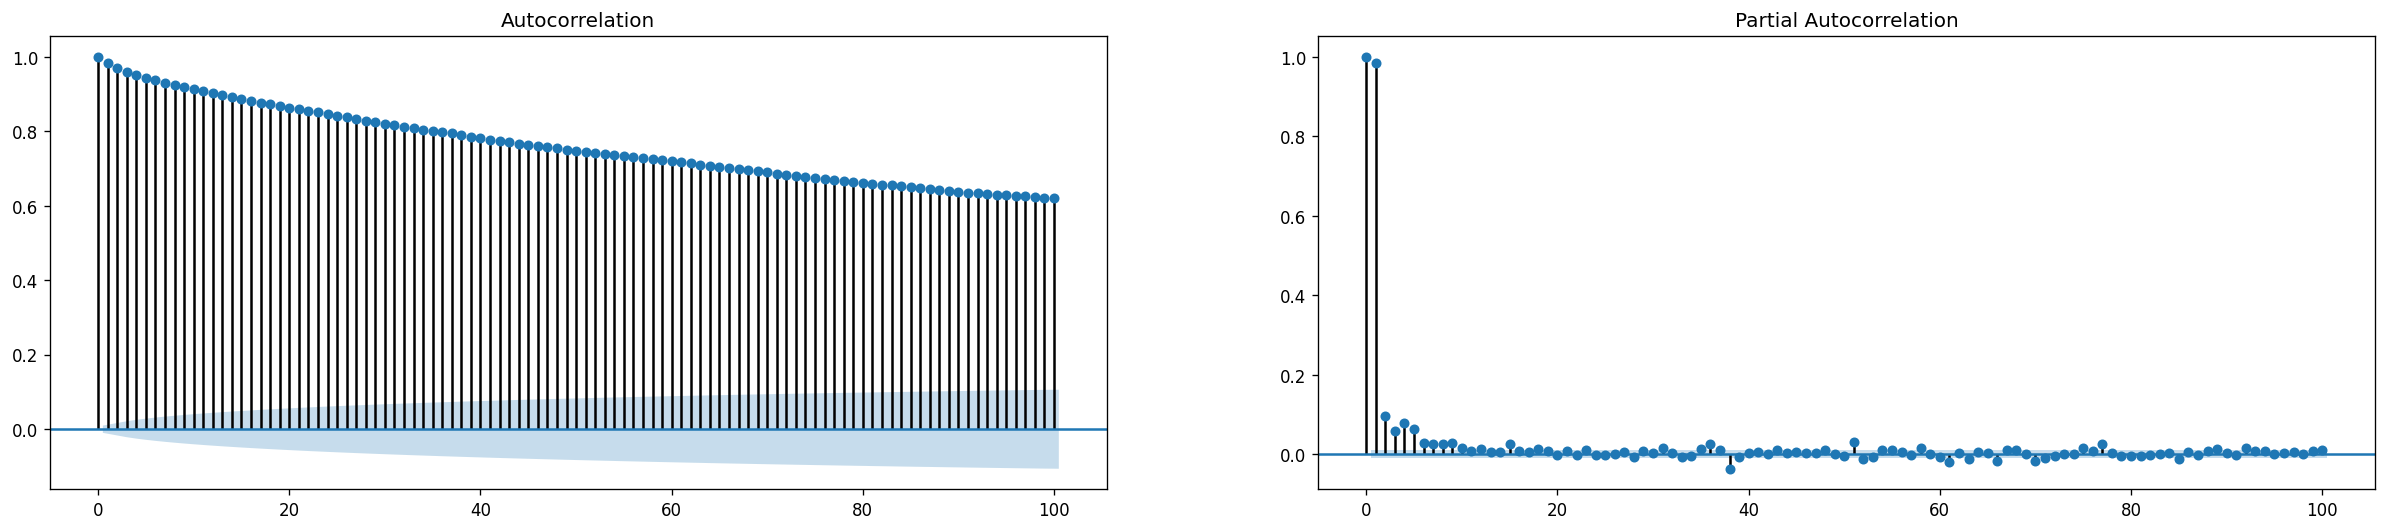

<IPython.core.display.Javascript object>

In [ ]:
tb = widgets.TabBar([columns[i] for i in range(len(columns))])

midnights = np.array([])
colors=np.array([])
count=0
for i in range(0,len(df.index),period_length):
  midnights=np.append(midnights,df.index[i])
  if count <14 or count >=28:
    colors=np.append(colors,'green')
  else:
    if count >= 14 and count <21:
      colors=np.append(colors,'orange')
  count=count+1


for col in columns:
  with tb.output_to(col):
    plt.rcParams.update({'figure.figsize': (25, 10), 'figure.dpi': 120})
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.scatter(x=df.index, y=df[col], color='blue',s=0.5)
    ax.vlines(midnights, df[col].min(), df[col].max(), linestyles='dashed', colors=colors)
    fig.show();
    fig, ax = plt.subplots(1,2,figsize= (25, 5))
    plot_acf(df[col], lags =100, ax=ax[0])
    plot_pacf(df[col], lags =100,ax=ax[1])
    plt.show();


SARIMA

In [ ]:
params={
   '272':{'p':0,'d':1,'q':3},
   '430':{'p':2,'d':1,'q':1},
   '436':{'p':0,'d':1,'q':0},
   '480':{'p':0,'d':1,'q':0},
   '482':{'p':2,'d':1,'q':2},
   '776':{'p':5,'d':1,'q':2},
   '777':{'p':0,'d':1,'q':0},
   '780':{'p':2,'d':0,'q':3},
   '781':{'p':2,'d':0,'q':3},
   '782':{'p':3,'d':1,'q':2},
   '784':{'p':2,'d':1,'q':5},
   '908':{'p':1,'d':1,'q':1},
   '909':{'p':1,'d':1,'q':1},
   '910':{'p':1,'d':1,'q':1},
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

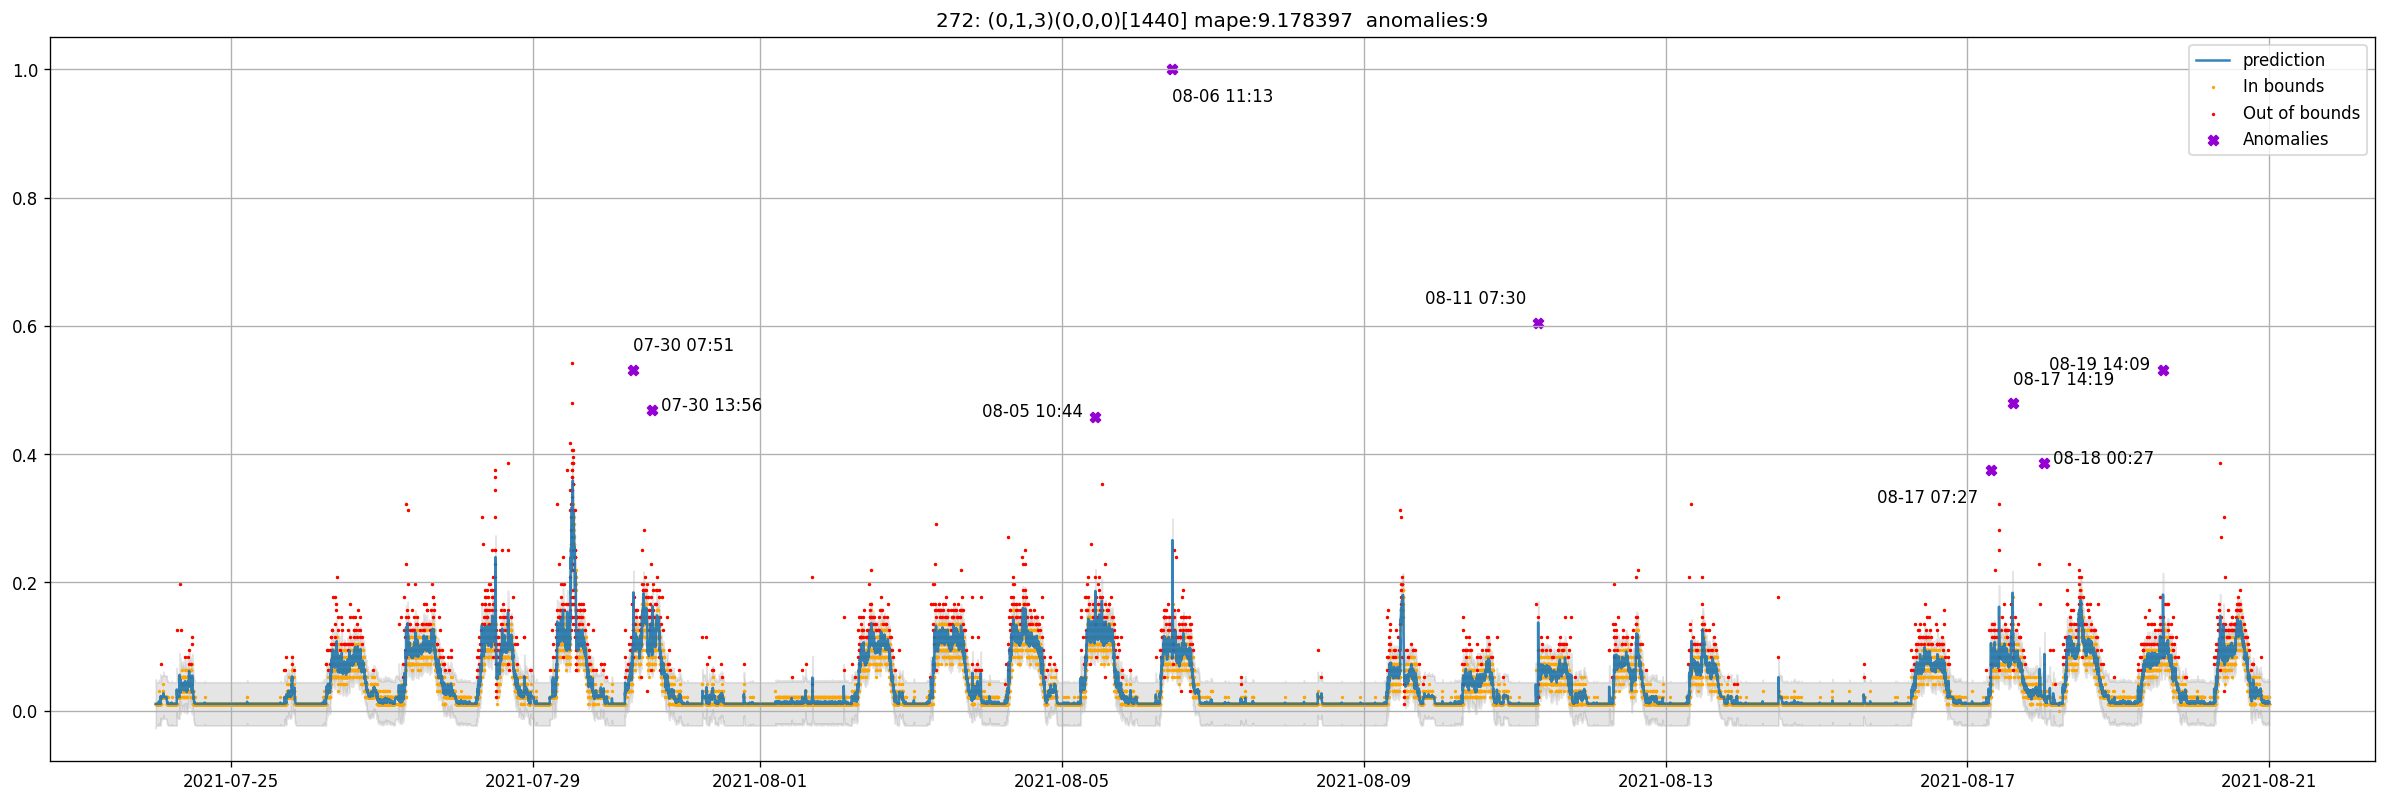

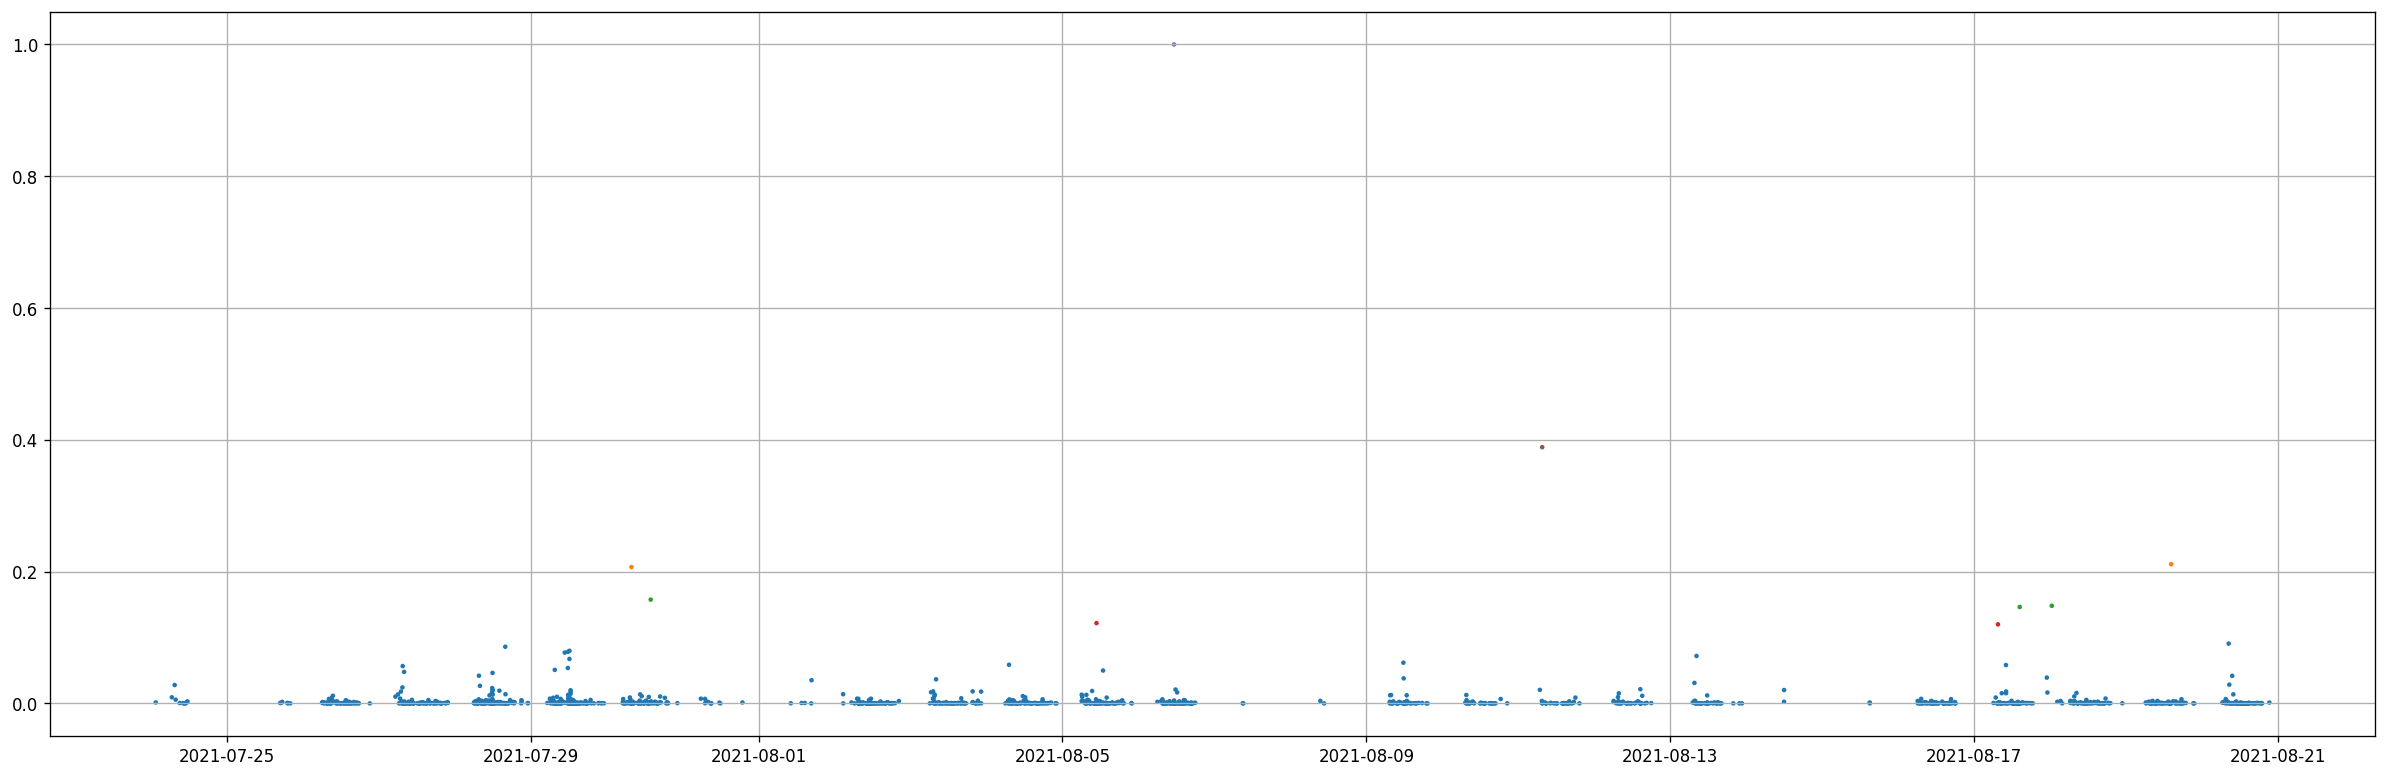

272 execution time :24.88766360282898 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

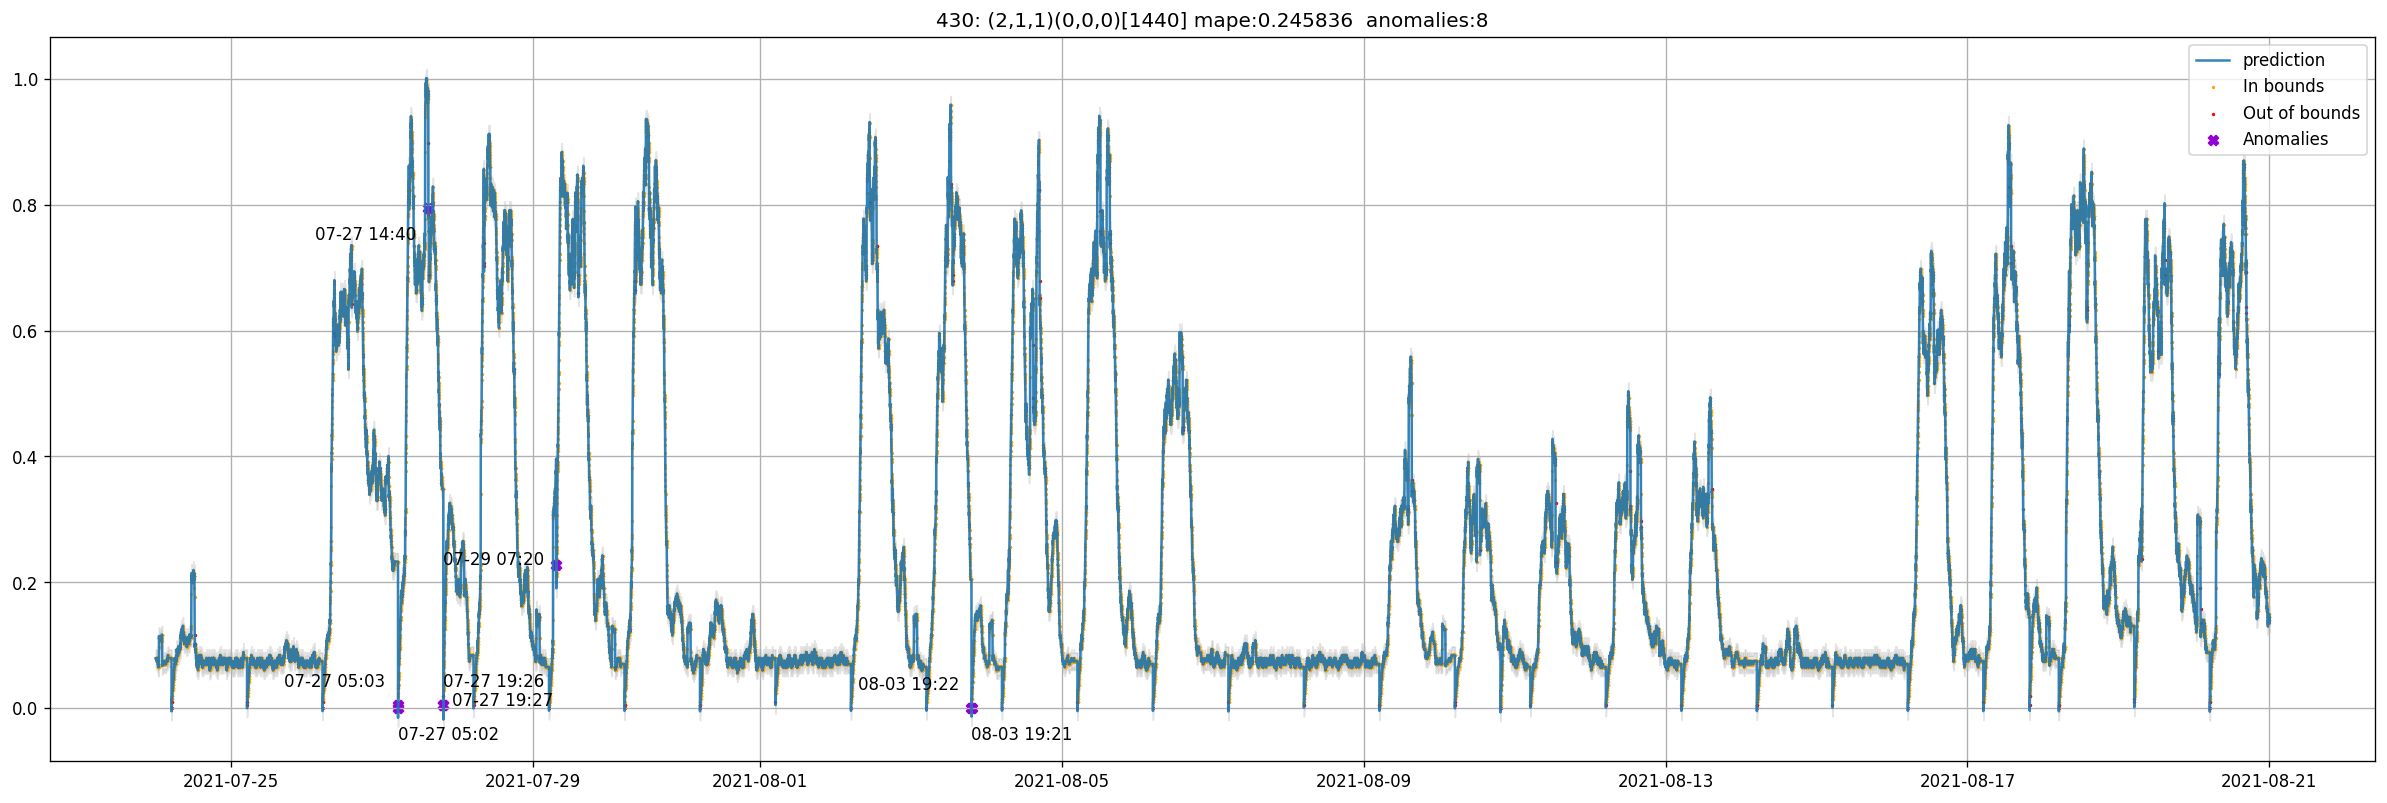

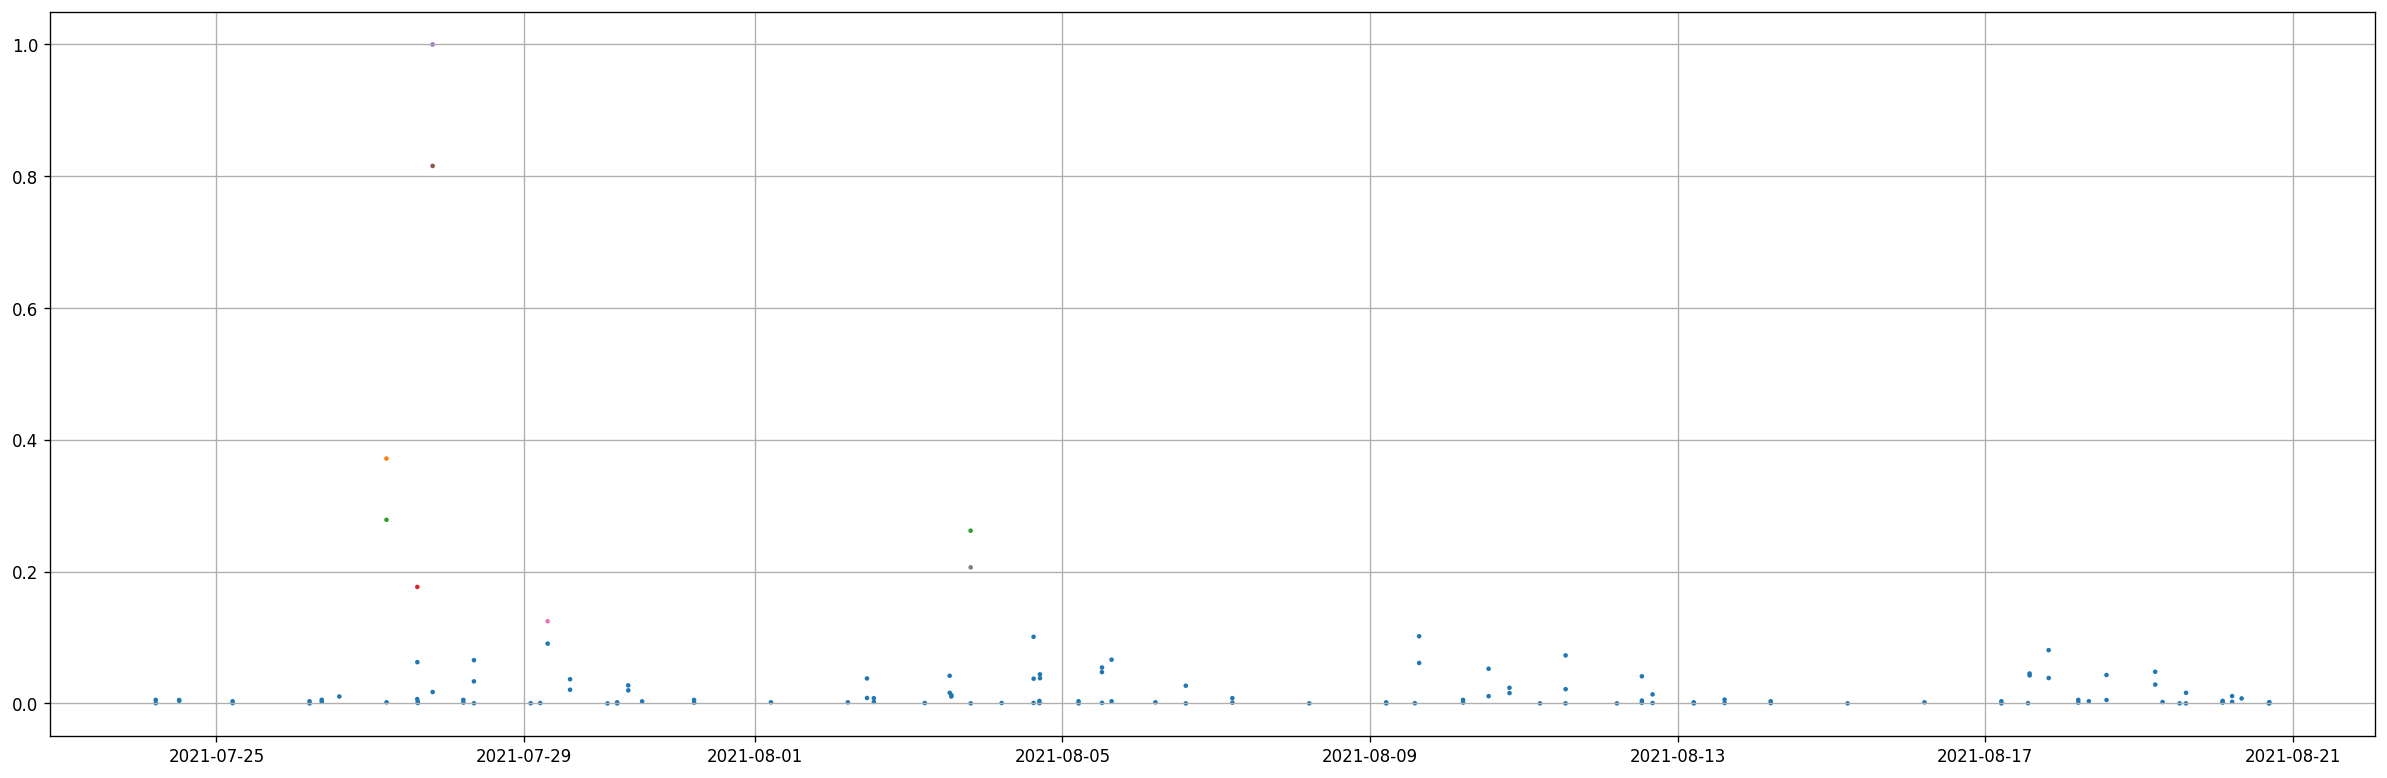

430 execution time :16.57254981994629 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

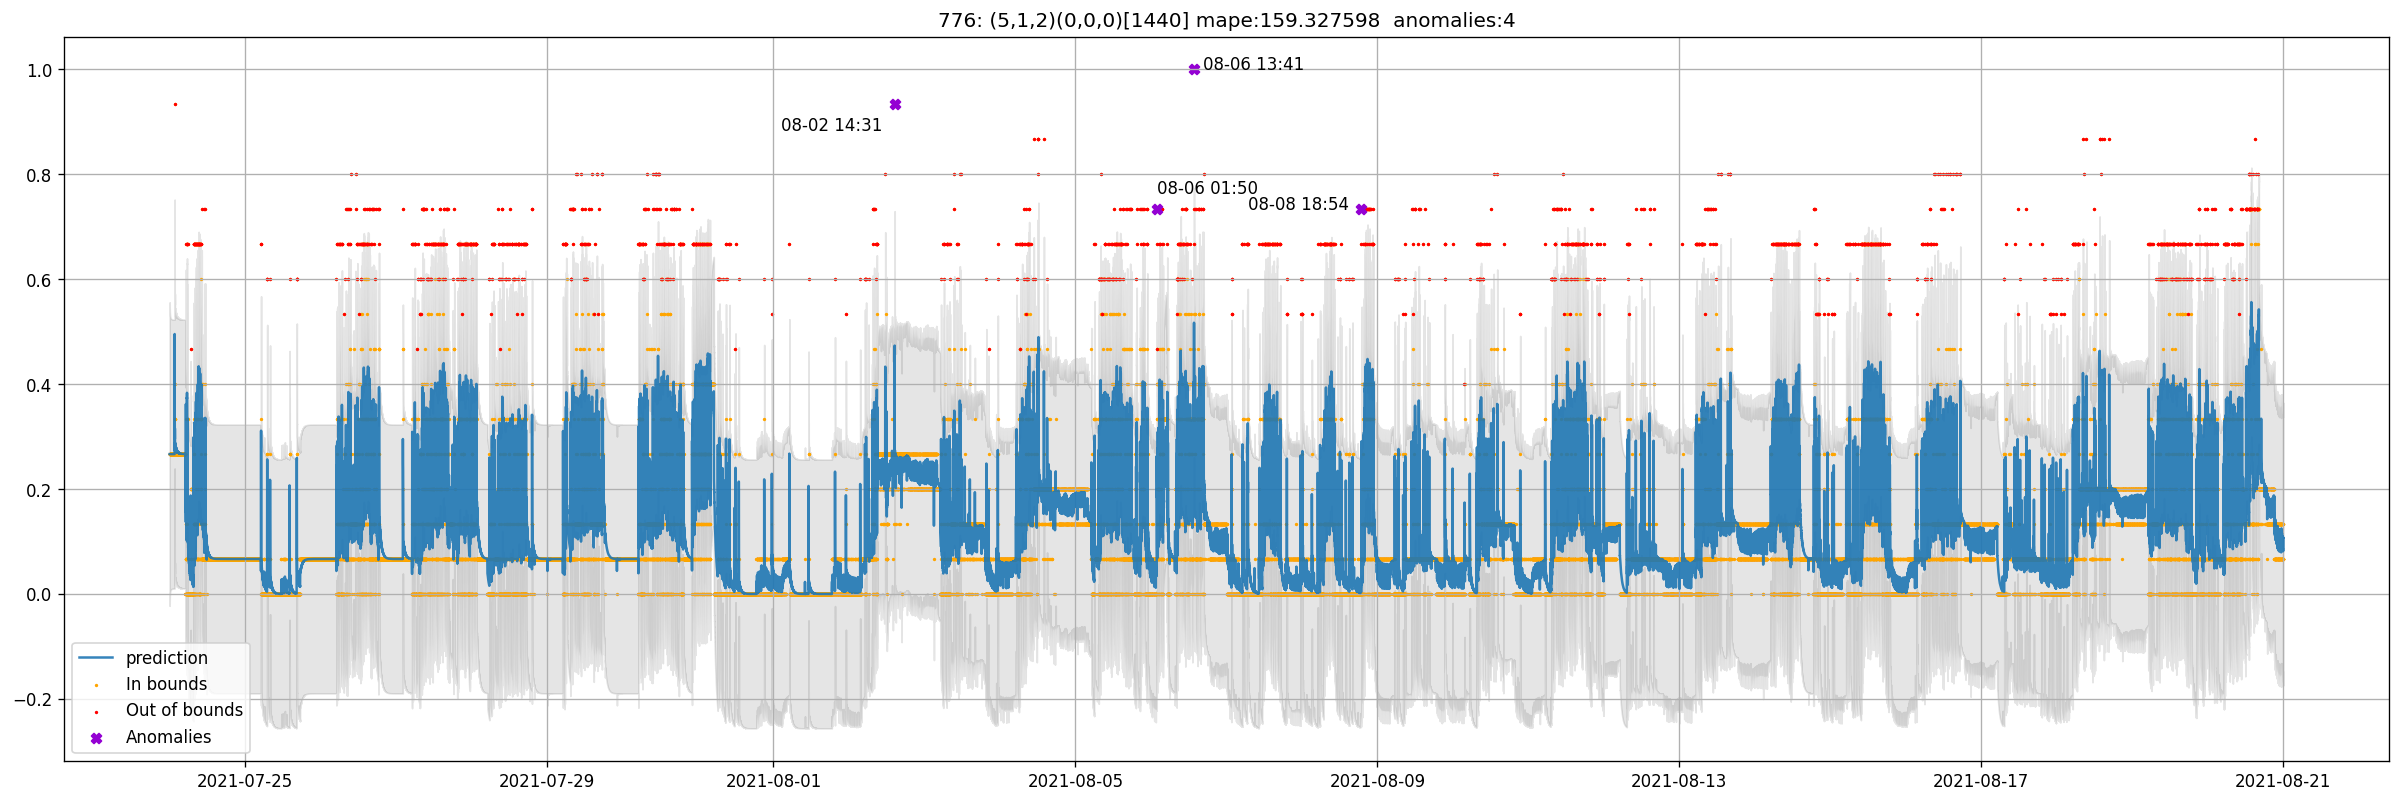

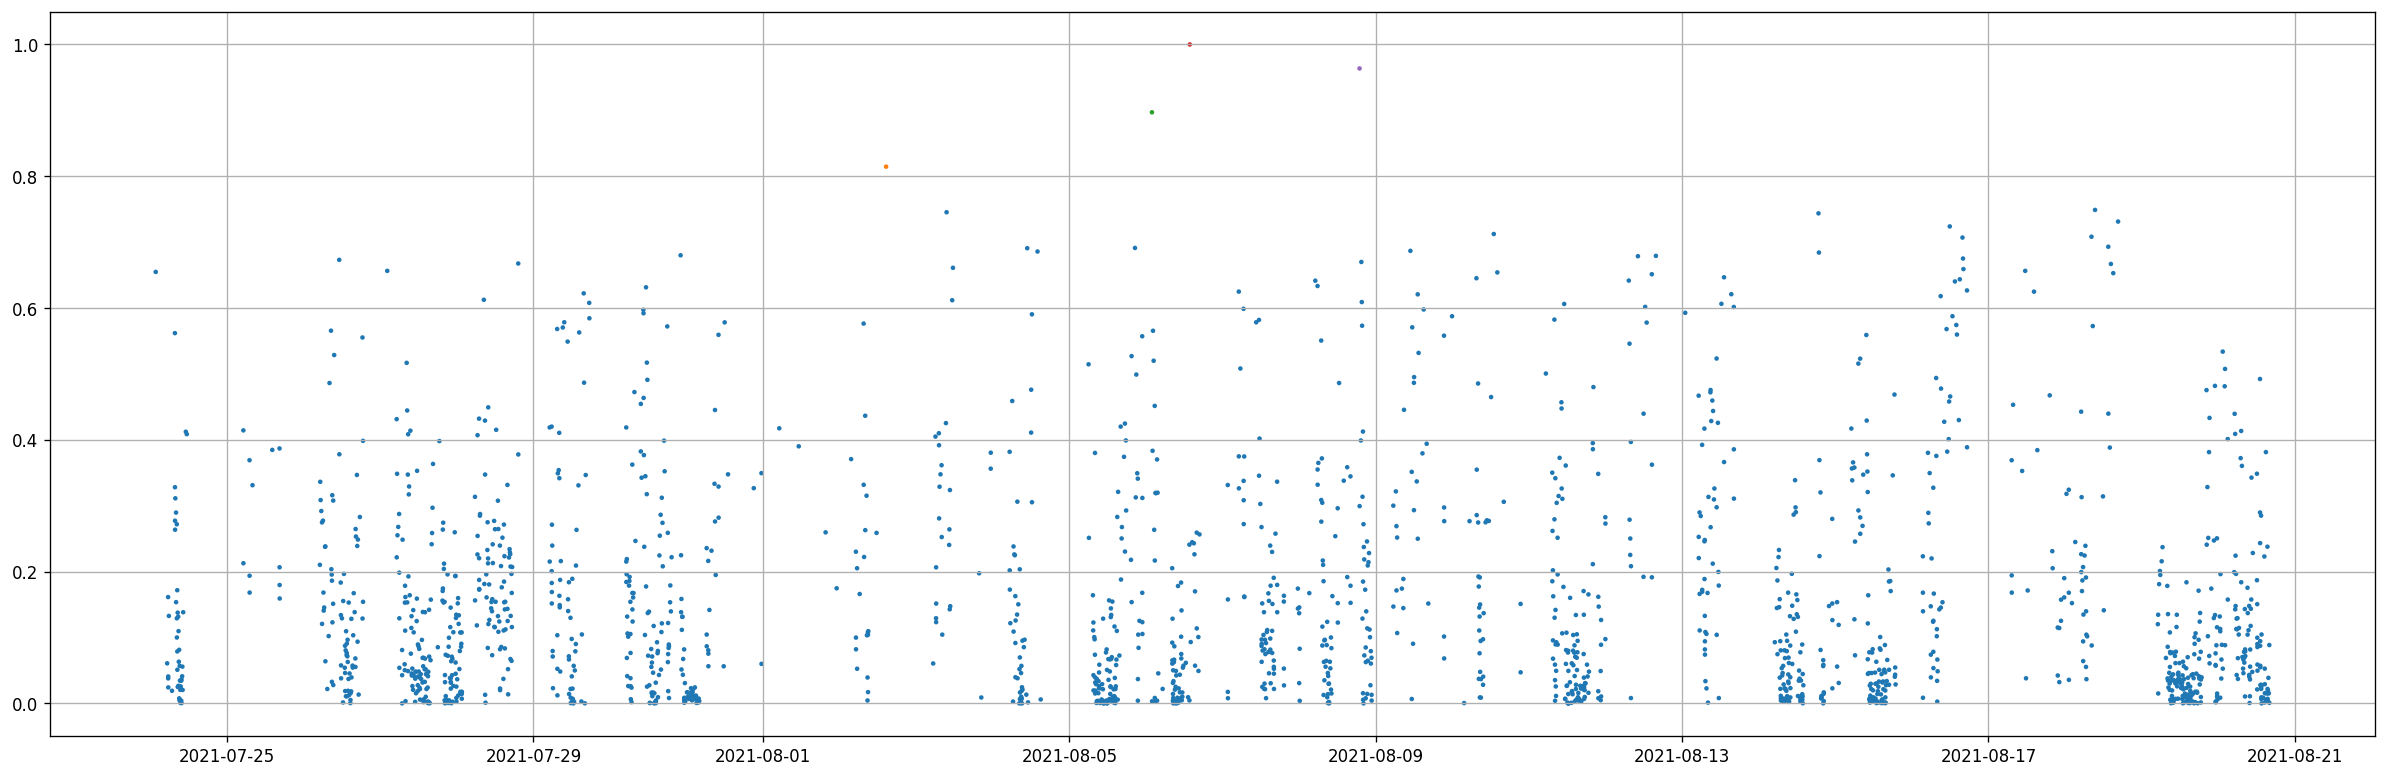

776 execution time :50.51109552383423 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

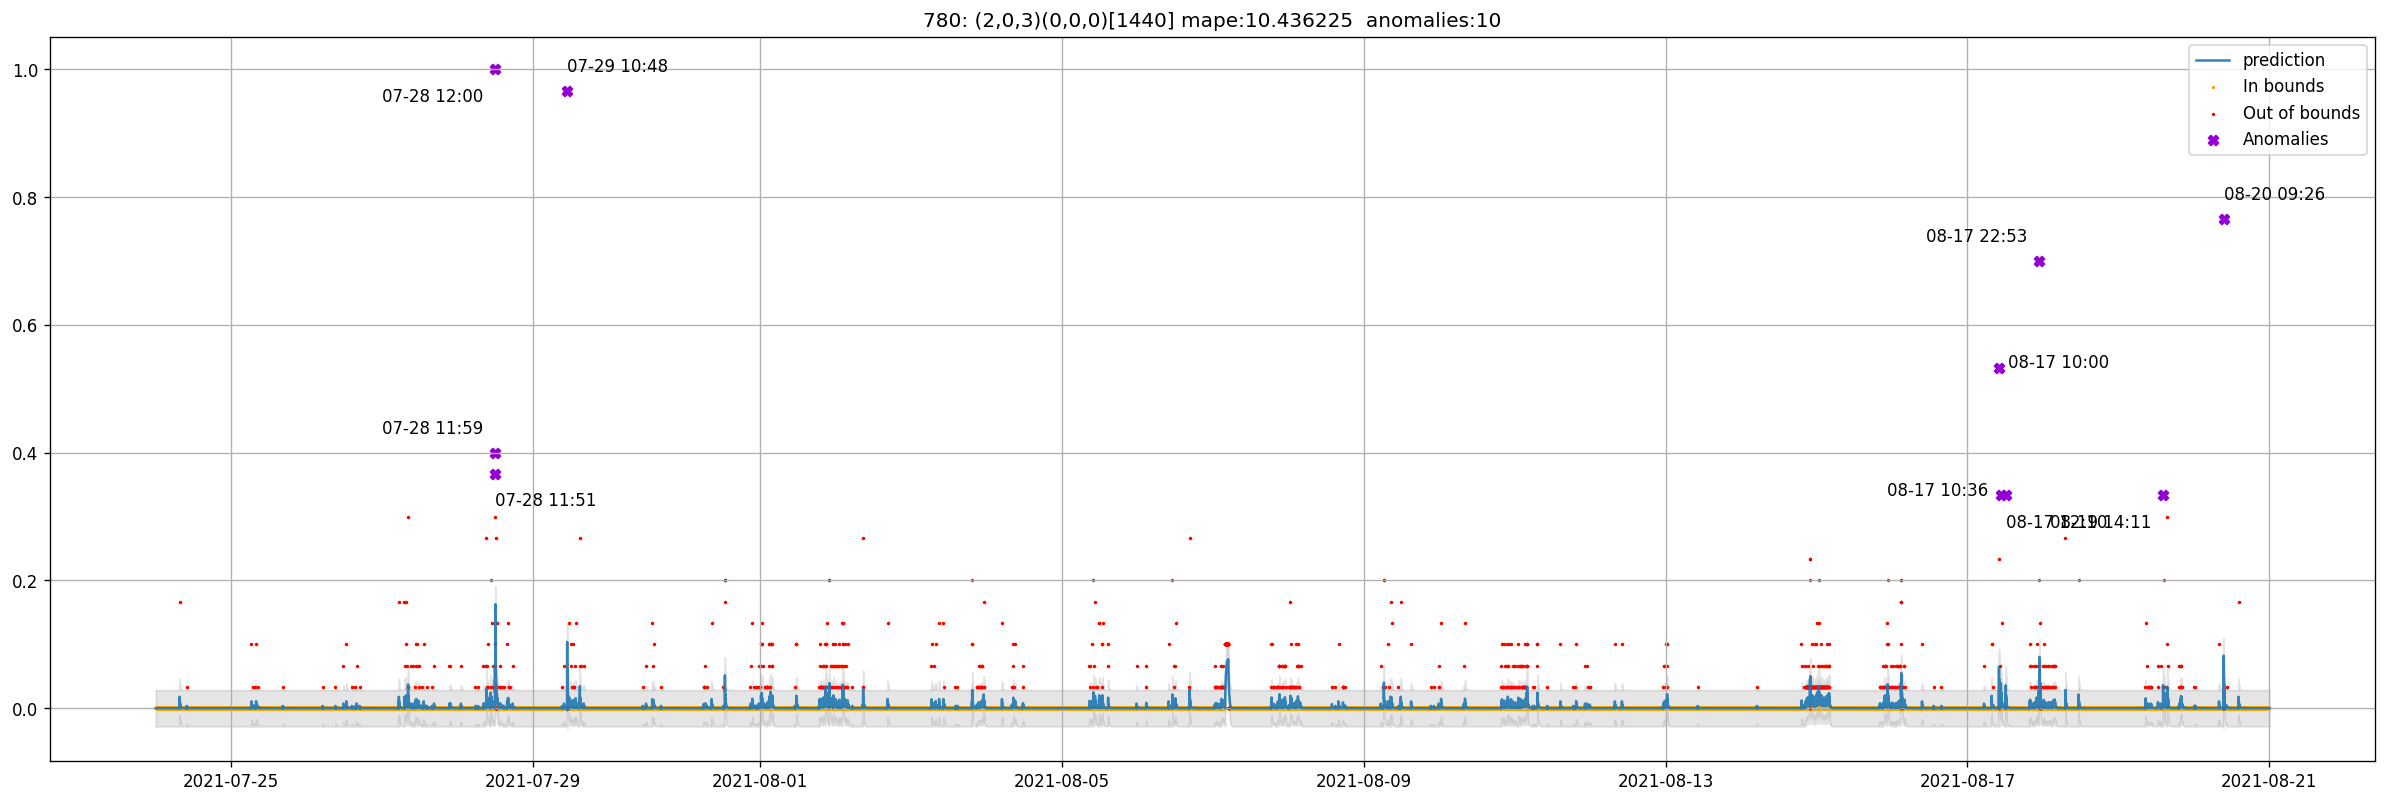

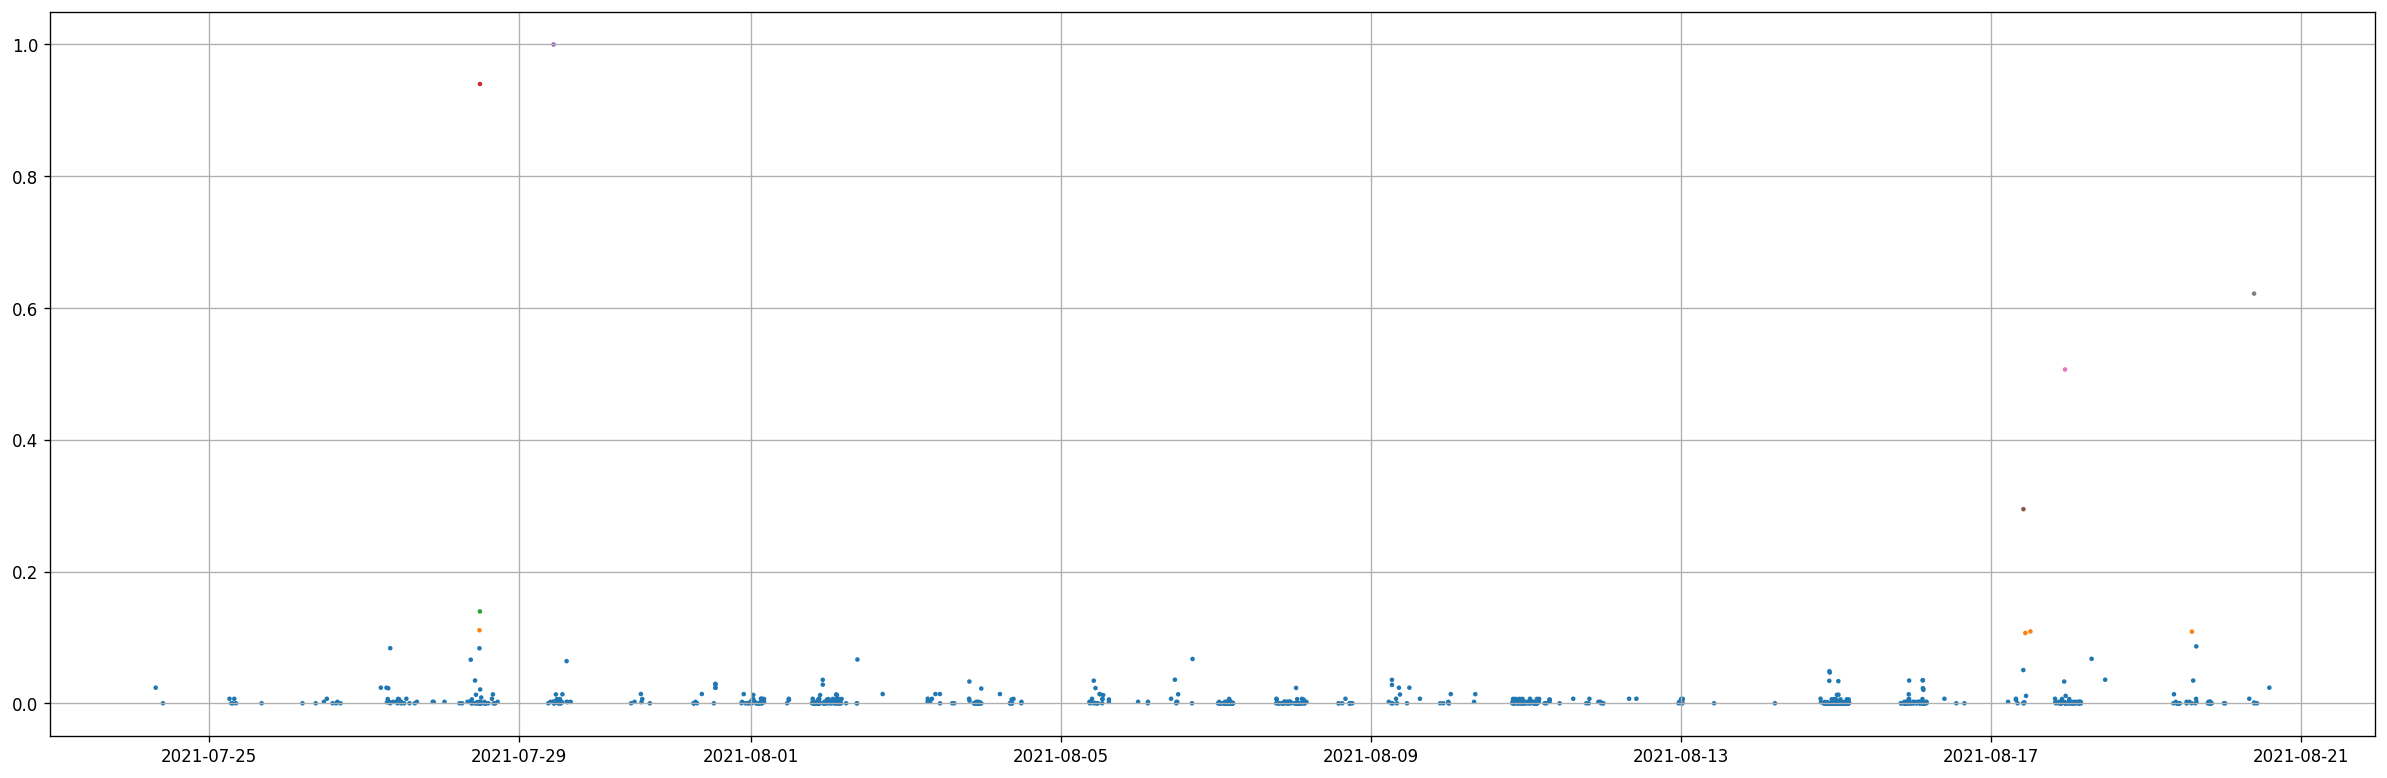

780 execution time :38.80133390426636 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

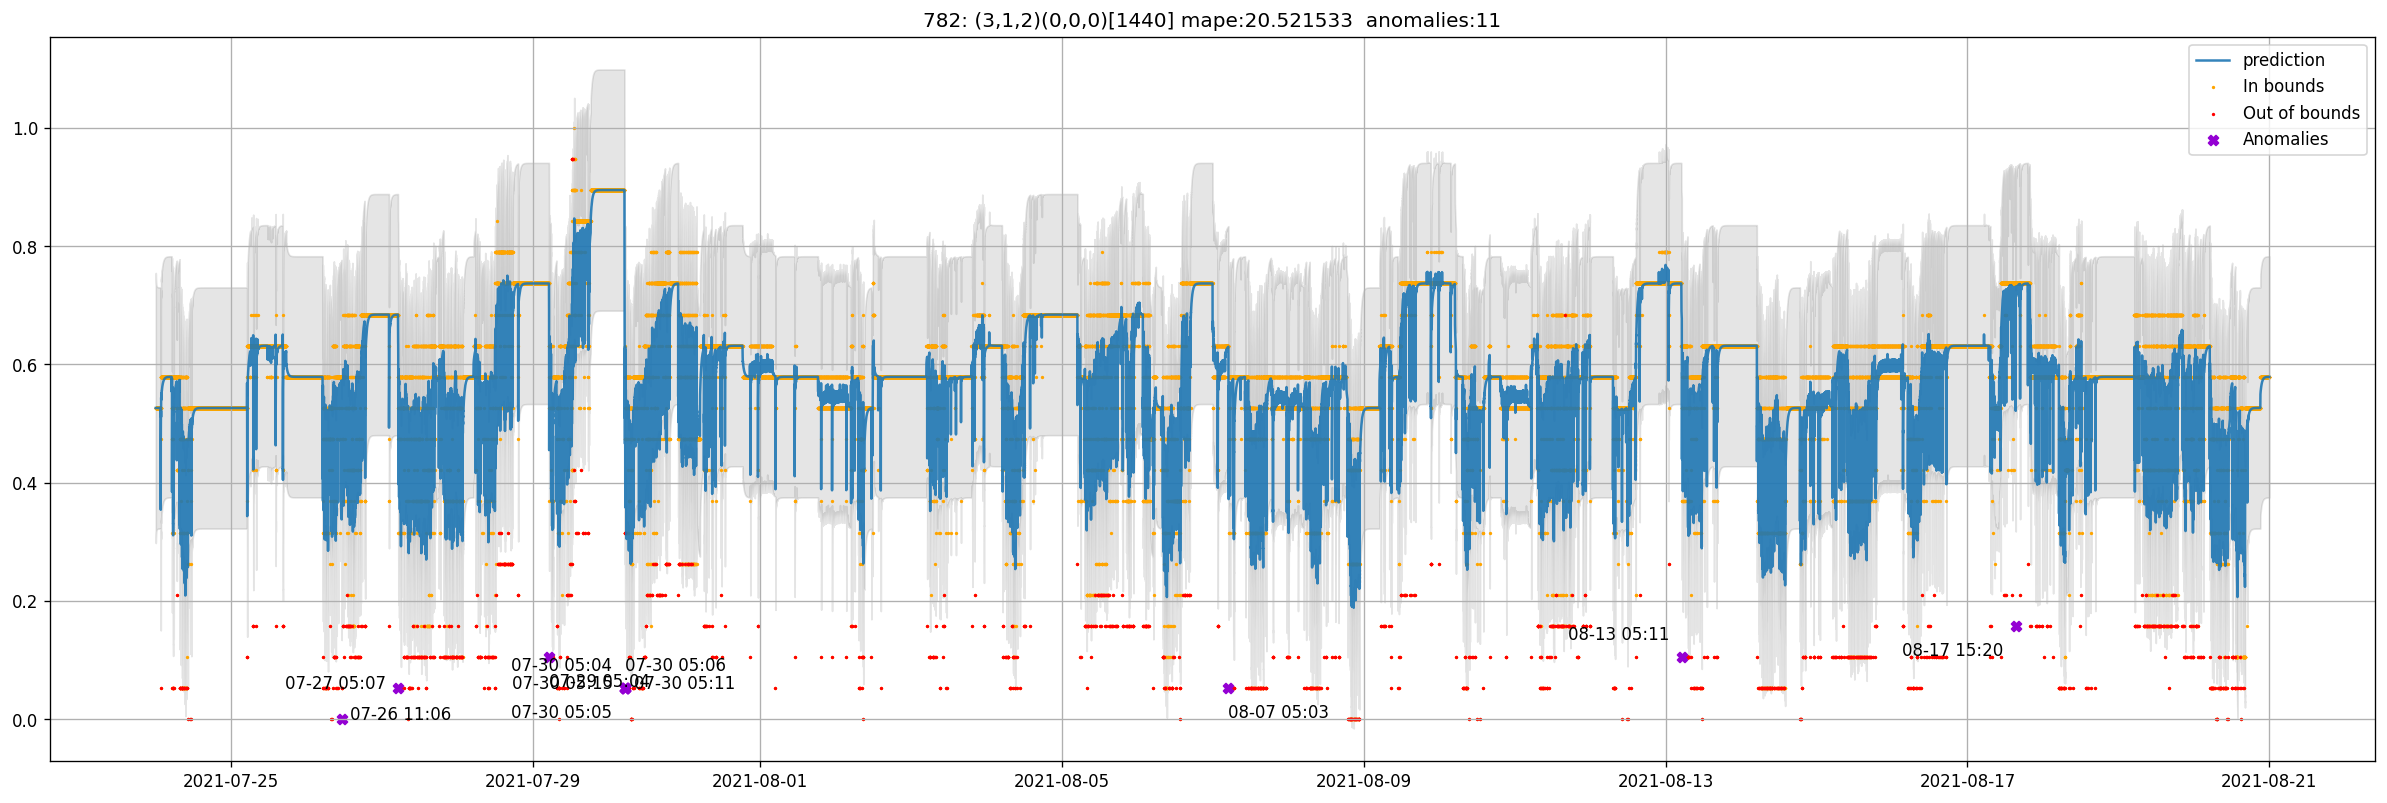

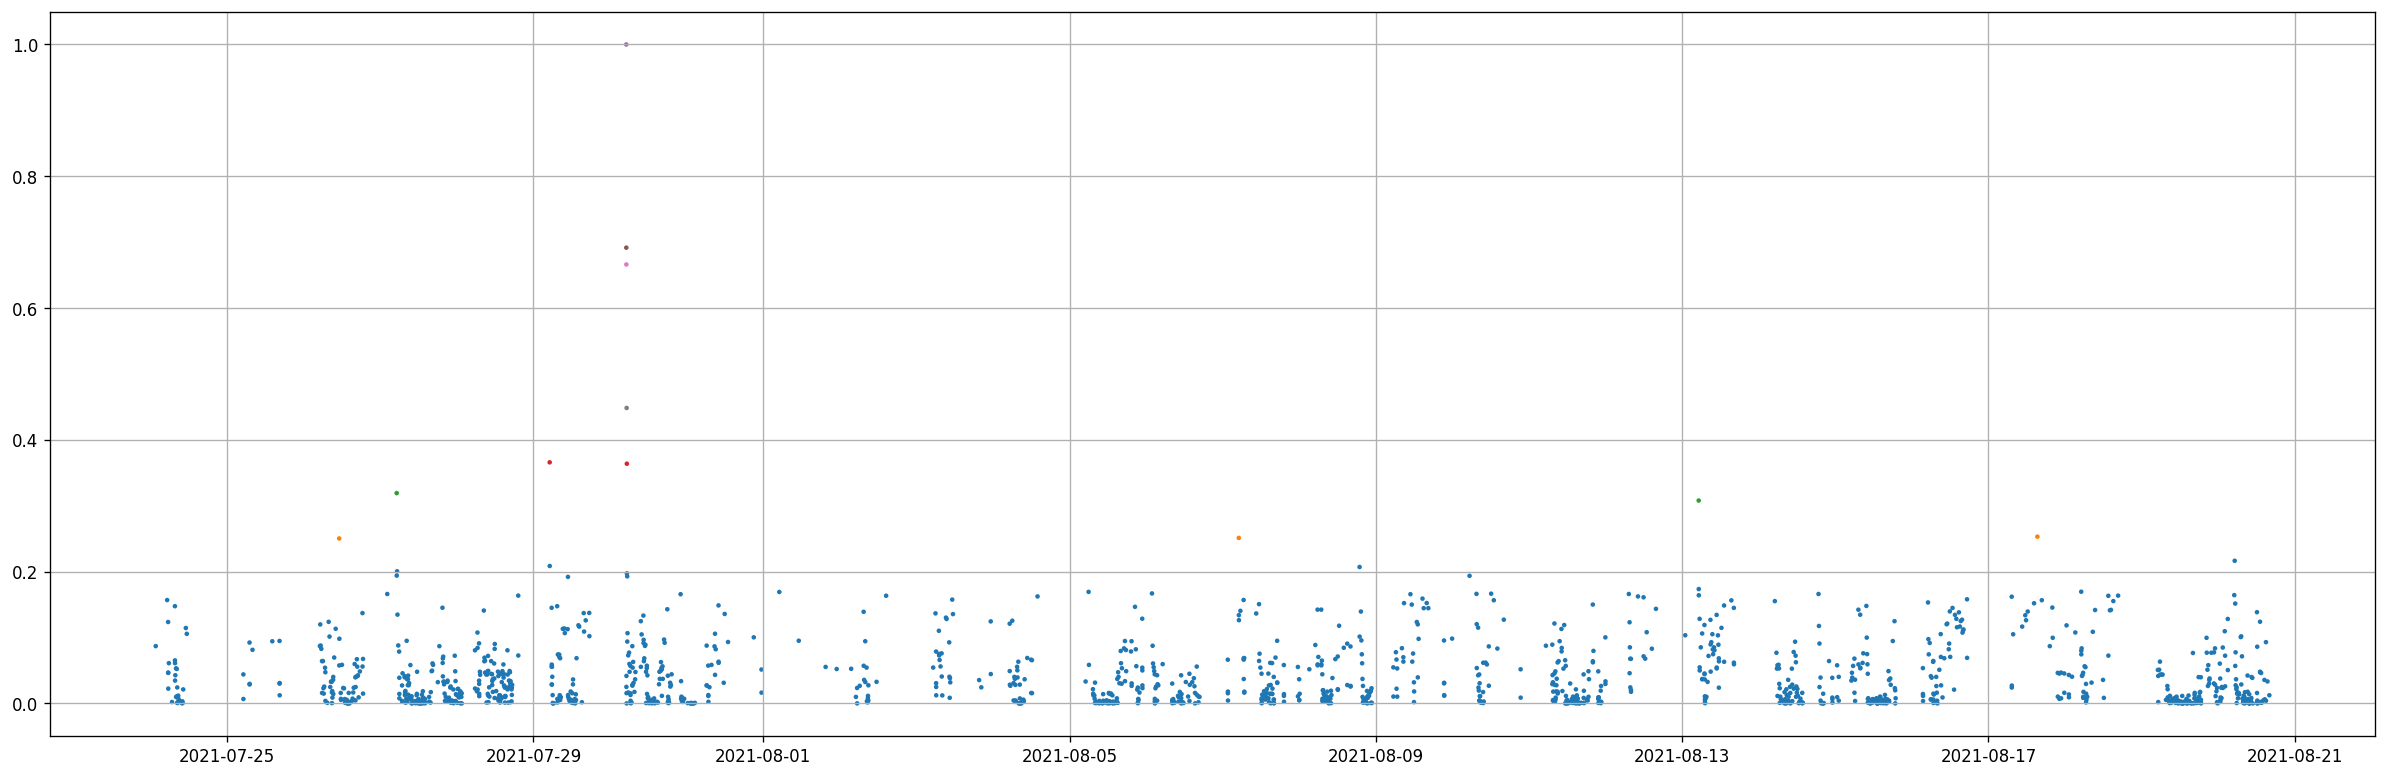

782 execution time :37.01205372810364 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

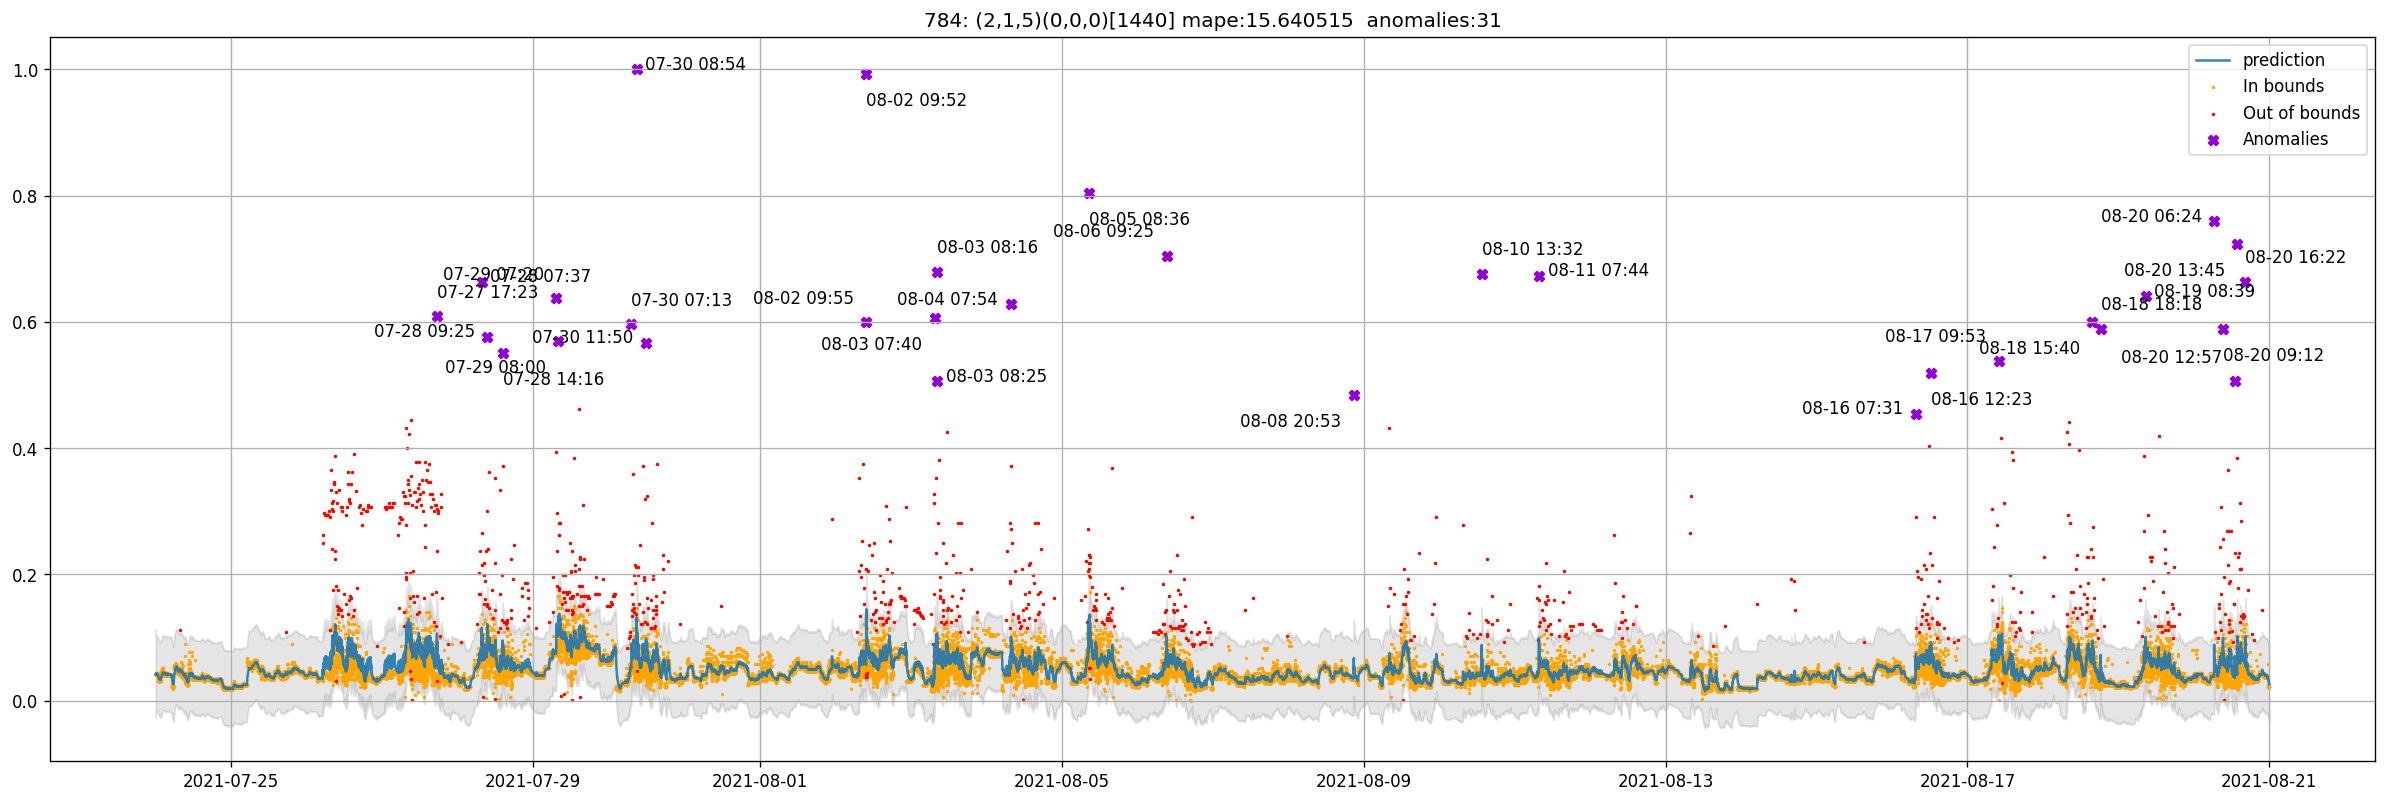

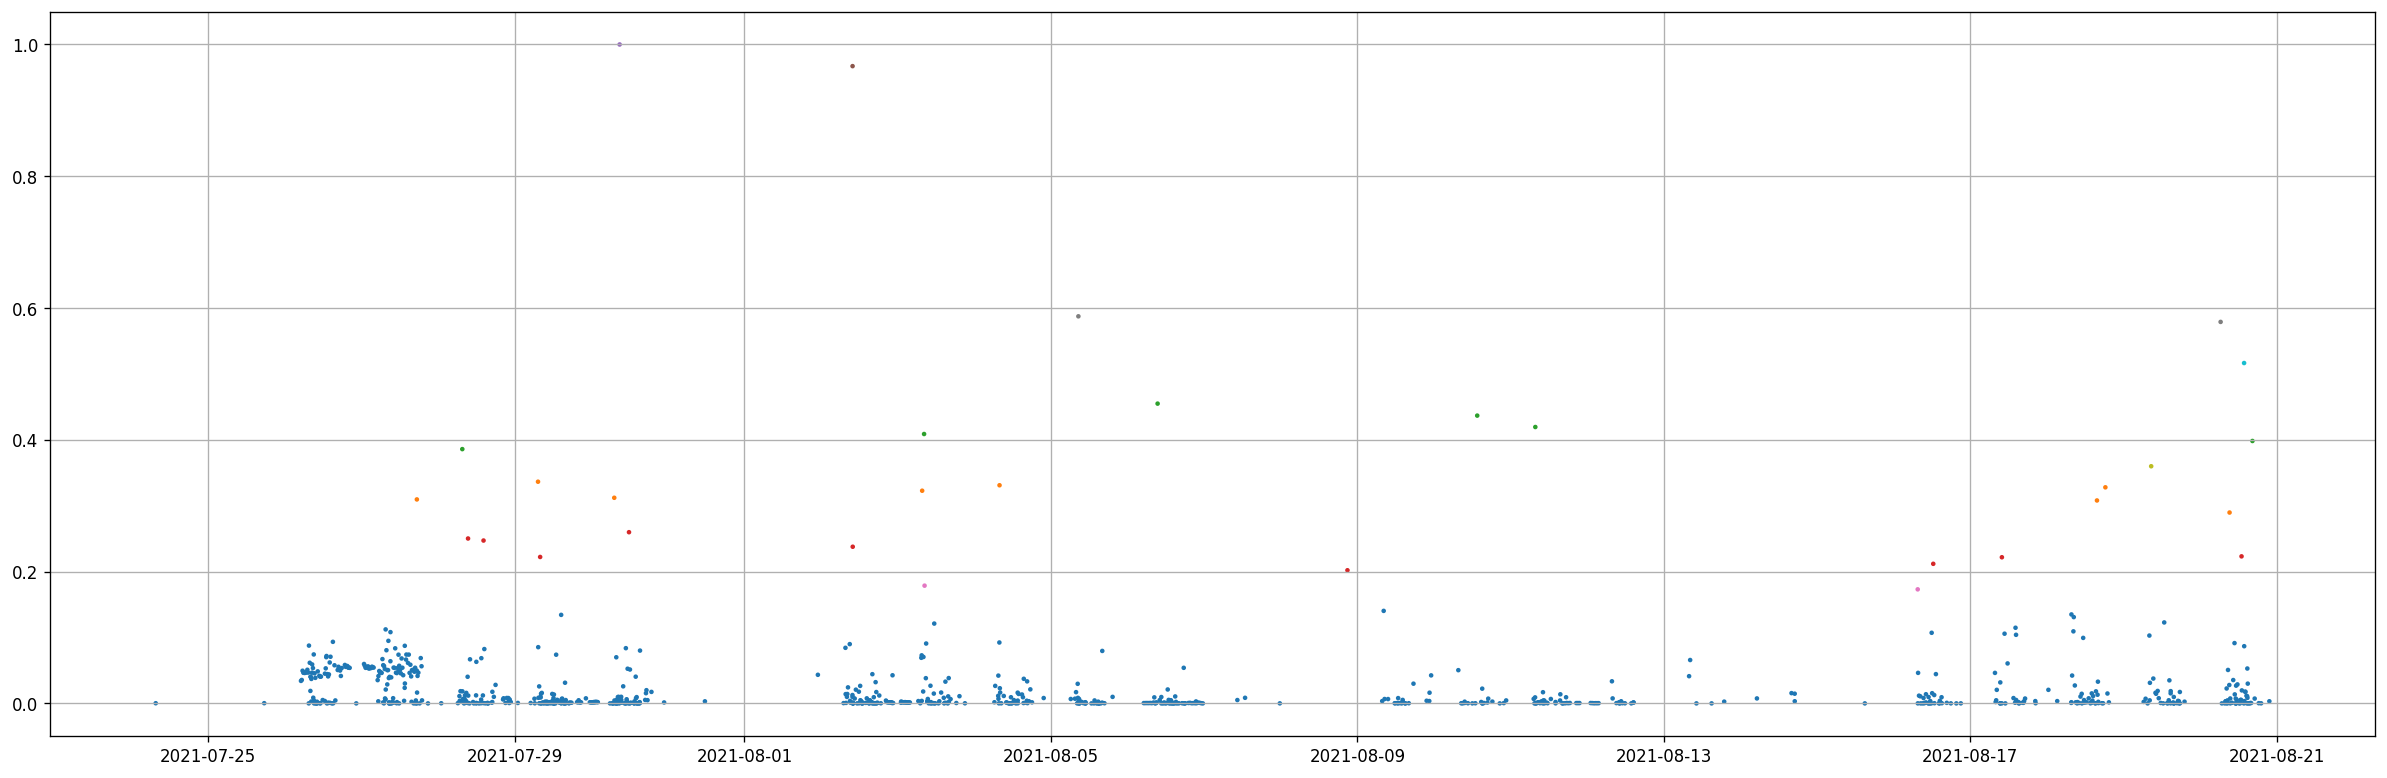

784 execution time :60.07904815673828 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

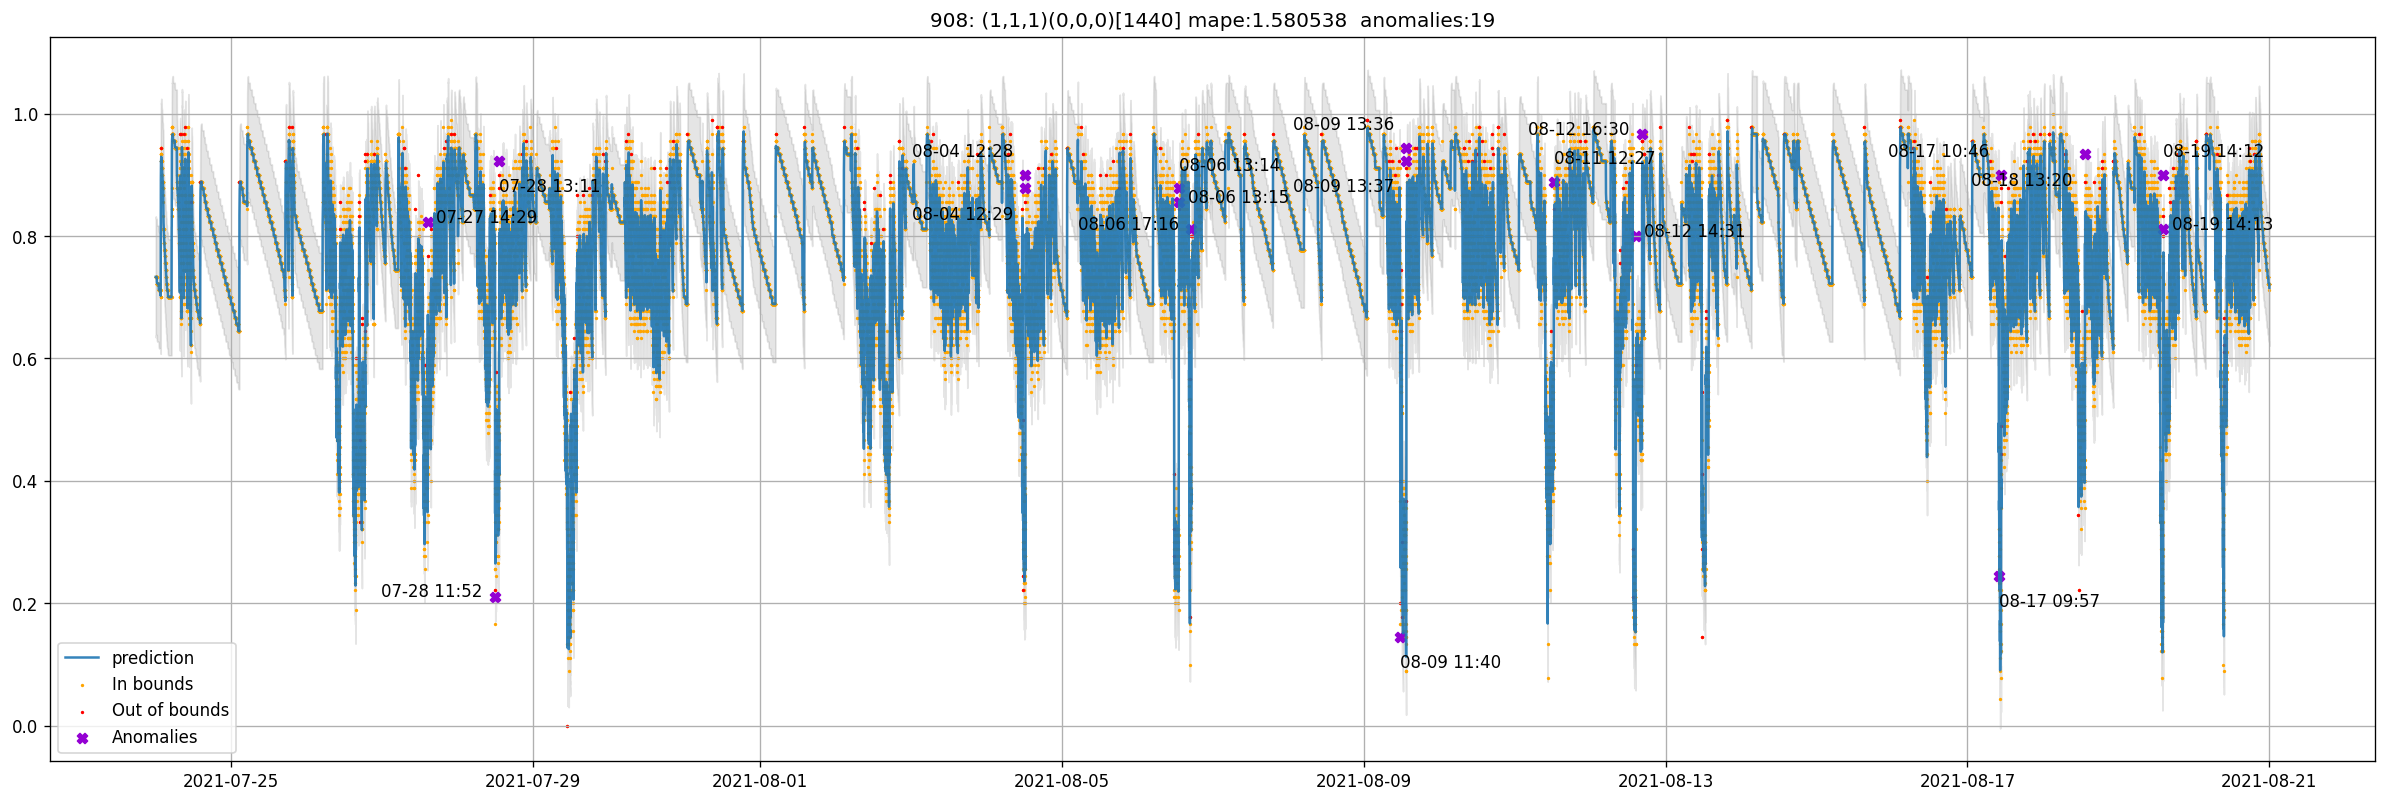

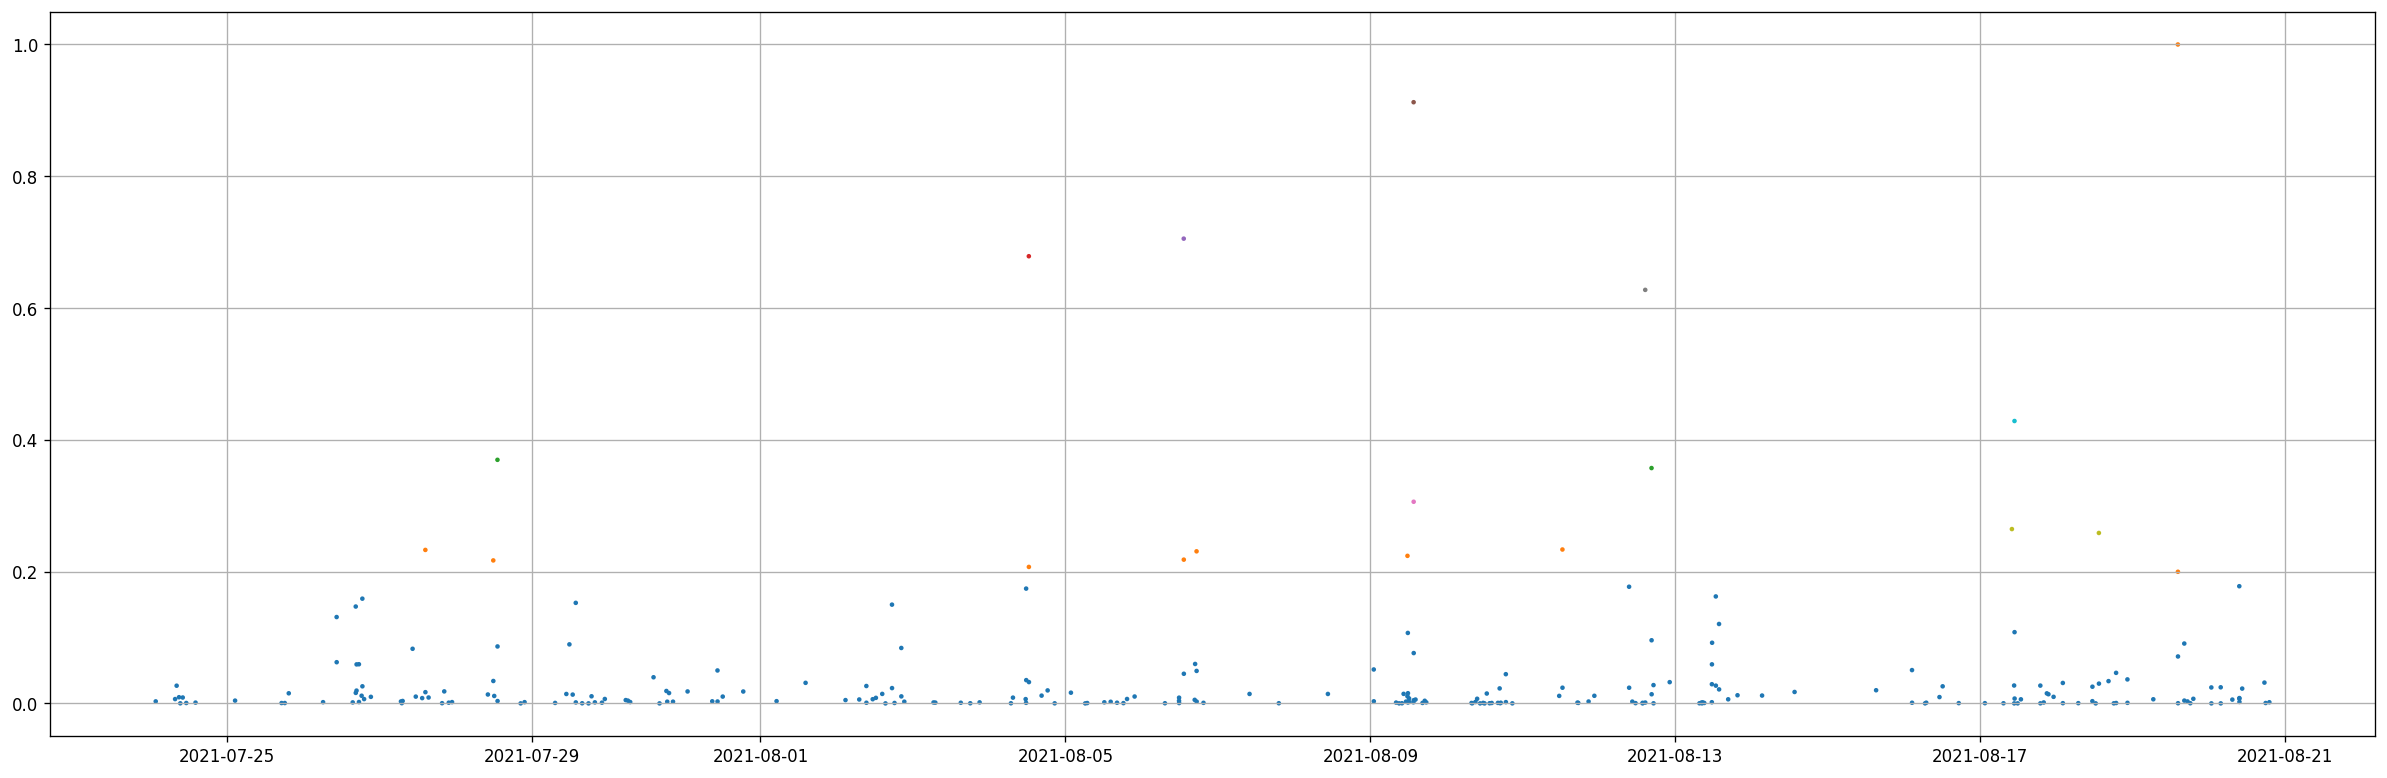

908 execution time :17.294667720794678 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

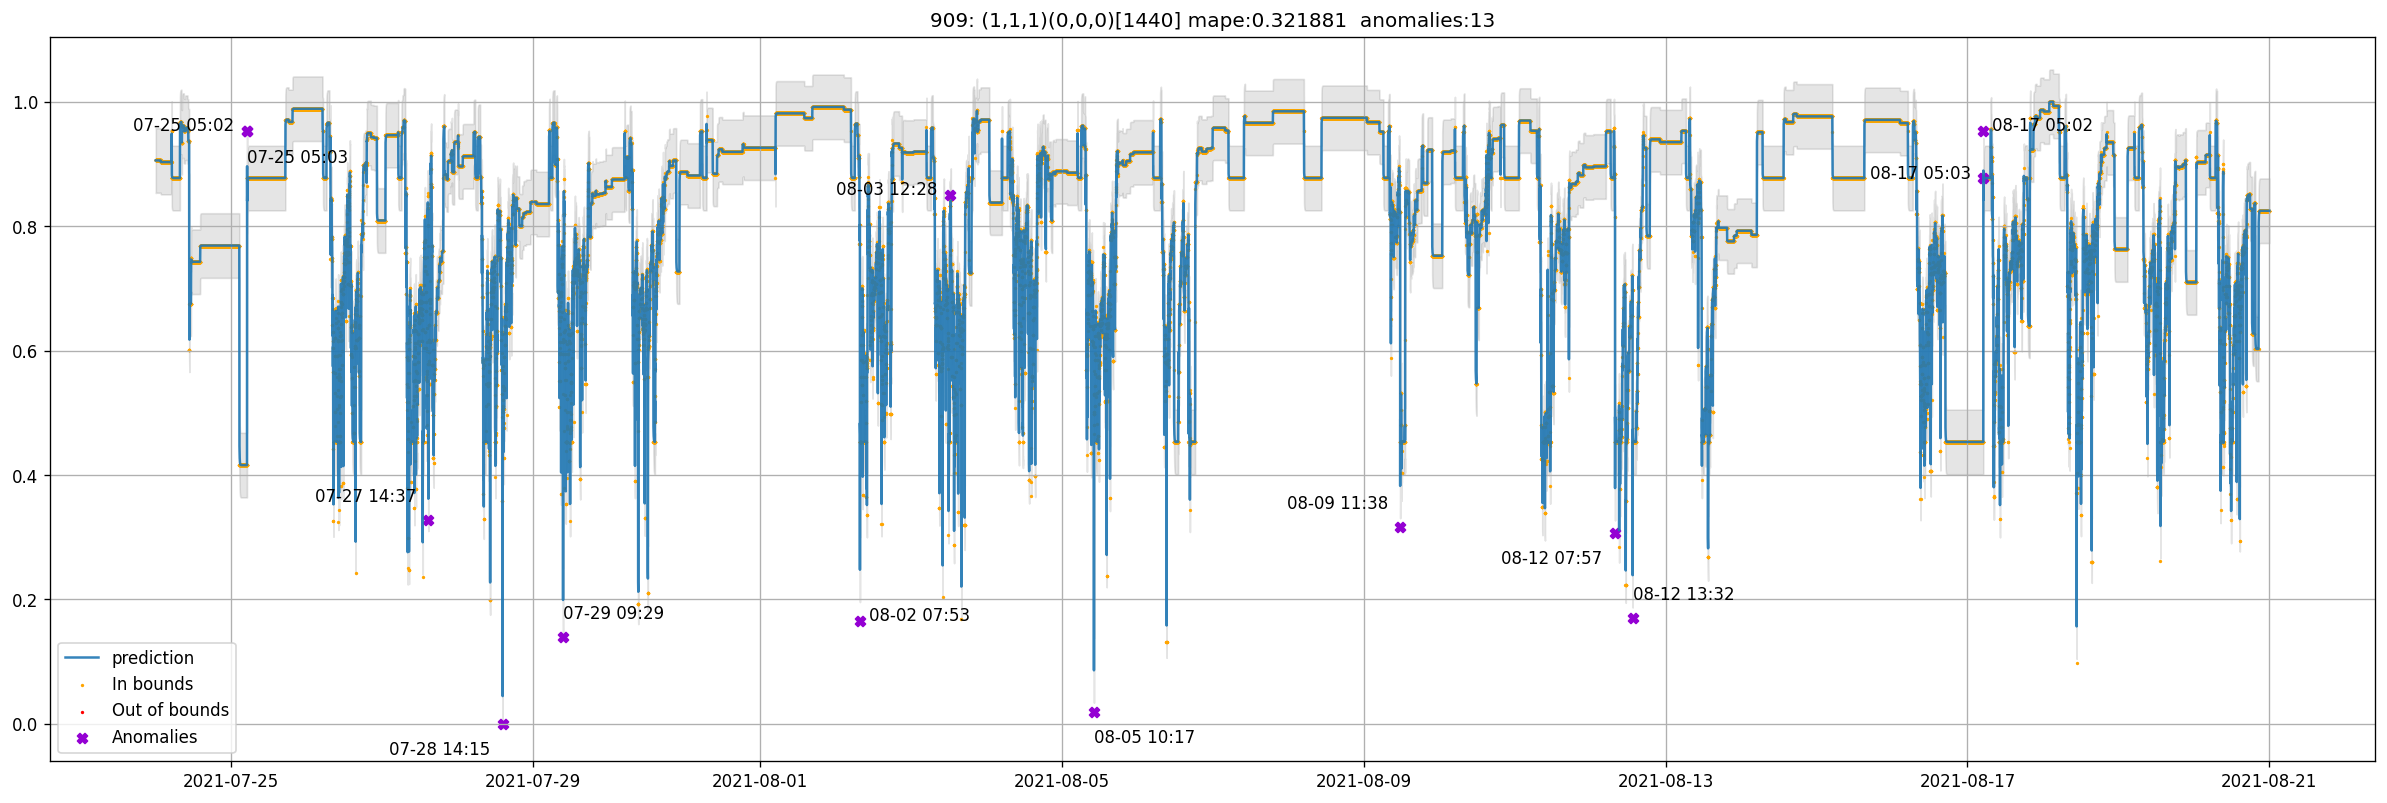

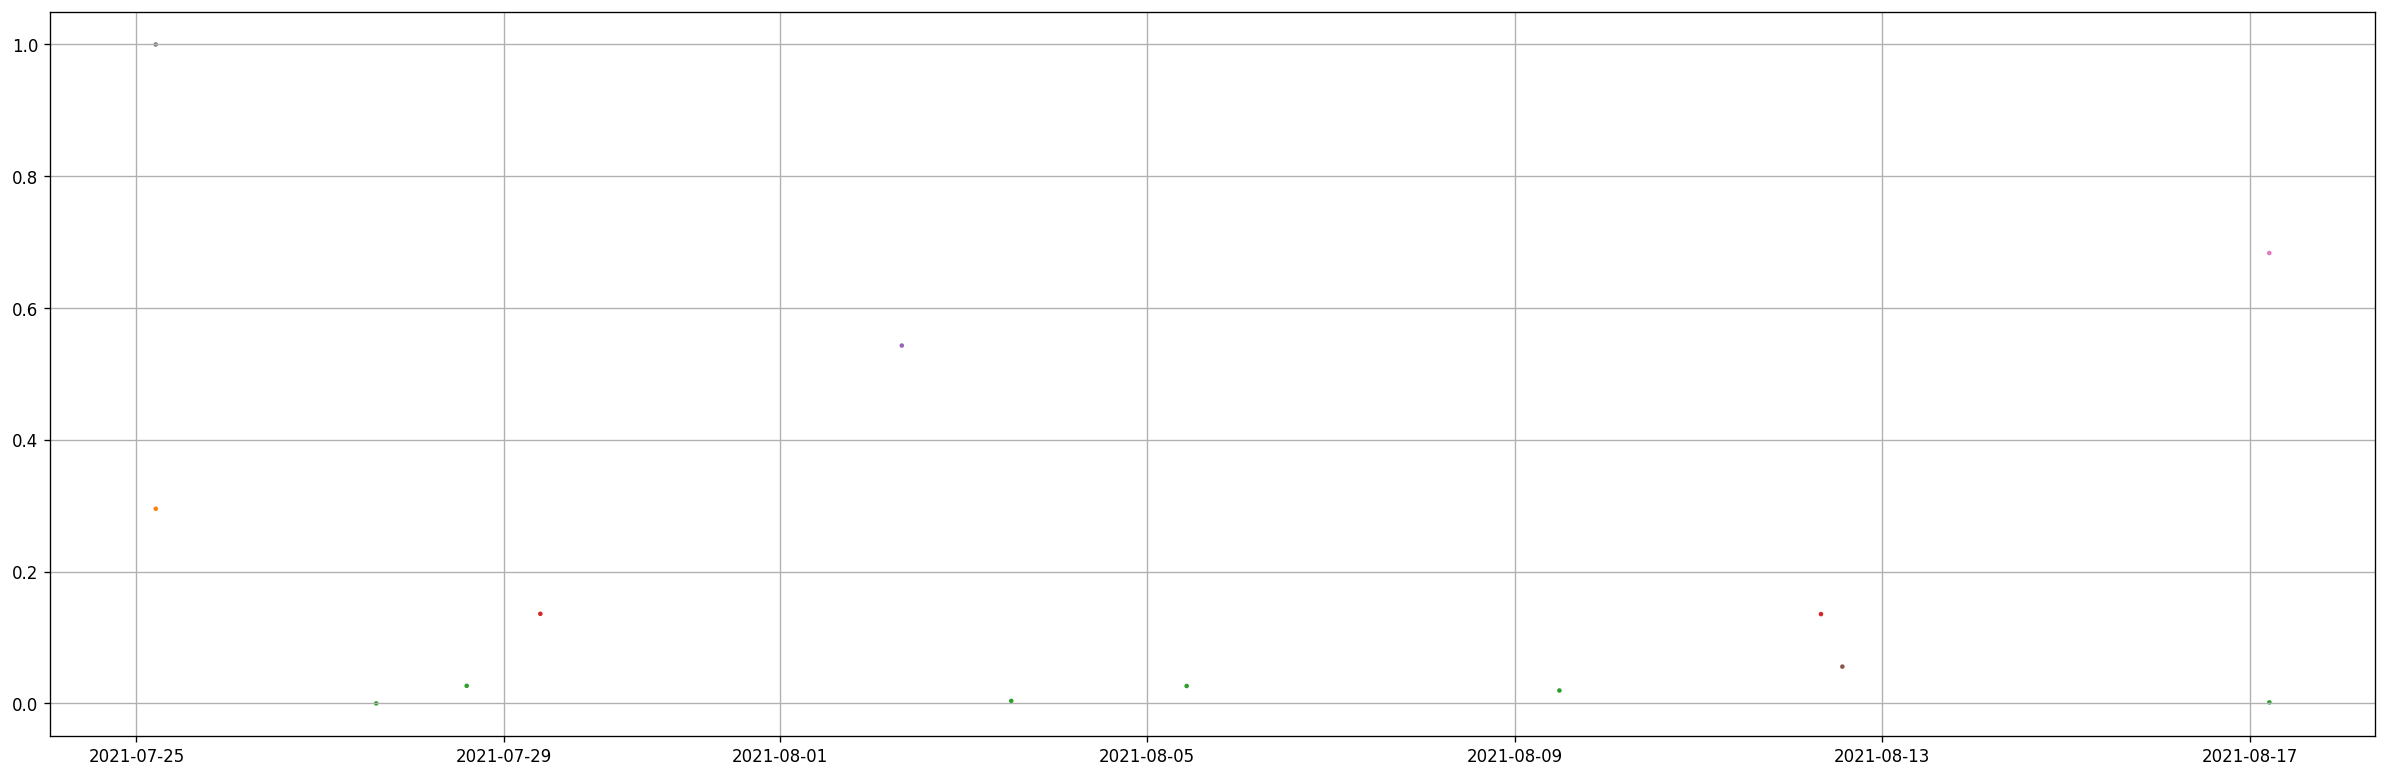

909 execution time :15.711661100387573 seconds


<IPython.core.display.Javascript object>

In [ ]:
start_time_all = time.time()
scaler = MinMaxScaler()
tb = widgets.TabBar([columns[i] for i in range(len(columns))])
tmp=0

all_anomalies=pd.DataFrame()

for col in columns:
    start_time = time.time()
    #ts=df[col]
    ts=pd.DataFrame(scaler.fit_transform(df[col].values.reshape(-1,1)))
    ts.index = pd.DatetimeIndex(df[col].index)
    ts=ts.asfreq(freq='60s',method='ffill')

    p=params[col]['p']
    d=params[col]['d']
    q=params[col]['q']
    m=period_length

    with warnings.catch_warnings():
      warnings.filterwarnings("ignore")
      model = SARIMAX(ts, order=(p, d, q), seasonal_order=(0, 0, 0, m)) #SARIMAX
      model_fit = model.fit(disp=1, solver='powell')

    fcast = model_fit.get_prediction(start=1, end=len(ts))
    ts_p = fcast.predicted_mean
    ts_p.index = pd.DatetimeIndex(ts.index)
    ts_p=ts_p.asfreq(freq='60s',method='ffill')

    ts_ci = fcast.conf_int()
    ts_ci.index = pd.DatetimeIndex(ts.index)
    ts_ci=ts_ci.asfreq(freq='60s',method='ffill')

    ts=ts+0.01
    ts_p=ts_p+0.01

    anomaly_scores=np.array([])
    
    sum=0;
    count=0;
    for i in range(0,len(ts),1):
      true_val=ts.iloc[i].values[0]
      upper_val=ts_ci['upper y'].iloc[i]
      lower_val=ts_ci['lower y'].iloc[i]
      anomaly_score=0
      width=upper_val-lower_val

      k=2   #############################

      sum=sum+abs(true_val-ts_p.iloc[i])/true_val
      count=count+1

      if true_val>upper_val :
        anomaly_score=(true_val-upper_val)*(true_val-upper_val)/width*k
      else :
        if lower_val>true_val :
          anomaly_score=(lower_val-true_val)*(lower_val-true_val)/width*k

      anomaly_scores=np.append(anomaly_scores,[anomaly_score])

    
    anomaly_scores=scaler.fit_transform(anomaly_scores.reshape(-1,1))
    anomaly_df=pd.DataFrame(anomaly_scores)
    anomaly_df.index = pd.DatetimeIndex(ts.index)
    anomaly_df=anomaly_df.asfreq(freq='60s',method='ffill')
    anomaly_df=anomaly_df[anomaly_df>0].dropna()

    clustering = DBSCAN(eps=0.02, min_samples=1).fit(anomaly_df)#DBSCAN


    labels=np.array(clustering.labels_)
    clusters, counts= np.unique(labels,return_counts=True)
    if counts[0]==1:
      labels[labels==0]=clusters.max()+1
    for i in range(1,len(clusters)):
      if counts[i]>10:
        labels[labels==clusters[i]]=0
    
    labels_df=pd.DataFrame(labels)
    labels_df.index=pd.DatetimeIndex(anomaly_df.index)

    

    out_of_bounds=labels_df[labels_df==0].dropna()
    anomalies_df=labels_df[labels_df > 0].dropna()

    all_anomalies=pd.concat([all_anomalies,pd.DataFrame(
        ({'x':anomalies_df.index.to_numpy(), 
          'y':np.full(len(anomalies_df.index),col)}))])


    mape_score=sum*100/count
    ts=ts-0.01
    ts_p=ts_p-0.01


    with tb.output_to(col):
      plt.rcParams.update({'figure.figsize': (25, 8), 'figure.dpi': 120})
      plt.plot(ts_p, label='prediction', alpha=0.9)
      plt.fill_between(ts_ci.index[1:],
                      ts_ci.iloc[1:, 0],
                      ts_ci.iloc[1:, 1], color='k', alpha=.1)
      plt.scatter(x=ts.index ,y=ts, color='orange', label='In bounds',s=1)
      plt.scatter(x=out_of_bounds.index , y=ts.loc[out_of_bounds.index], color='red', label='Out of bounds',s=1)
      plt.scatter(x=anomalies_df.index , y=ts.loc[anomalies_df.index], marker="X",color='darkviolet', label='Anomalies')

      hof=10000
      vof=0.05
      off=[(0,vof-0.02),
          (hof,0),
          (-13*hof,0),
          (0,-vof),
           (-13*hof,vof-0.02),
           (-13*hof,-vof),
           ]
      
      for j in anomalies_df.index: 
        cur_off=off[tmp%len(off)]
        tmp=tmp+1

        note=plt.annotate(str(j)[5:-3],(j,ts.loc[j][0]),
                          xytext=(j+datetime.timedelta(0, cur_off[0]),ts.loc[j][0]+cur_off[1]),
                          fontsize=10)
                         # bbox=dict(boxstyle="round", fc="white"))
      plt.legend()
      plt.title("%s: (%d,%d,%d)(0,0,0)[%d] mape:%f  anomalies:%d"%(col,p,d,q,m,mape_score,len(anomalies_df.index)))
      plt.grid()
      plt.show()

      ############
      plt.rcParams.update({'figure.figsize': (25, 8), 'figure.dpi': 120})
      plt.scatter(x=anomaly_df.index ,y=anomaly_df, c=colormap[labels],s=3)
      plt.grid()
      plt.show()
      ###########
      print(col+" execution time :"+str(time.time()-start_time)+" seconds")



In [ ]:
print("total execution time:"+str(time.time()-start_time_all)+" seconds")

total execution time:261.0911691188812 seconds


In [ ]:
#plt.scatter(x=all_anomalies['x'],y=all_anomalies['y'],c=all_anomalies['y'].astype(int))

dates, counts= np.unique(all_anomalies['x'],return_counts=True)
for i in dates:
  if(len(all_anomalies.loc[all_anomalies['x']==i])>1):
    print(all_anomalies.loc[all_anomalies['x']==i])

                    x    y
5 2021-07-29 07:20:36  430
4 2021-07-29 07:20:36  784
